# Khai báo thư viện

In [1]:
import numpy as np
from windrose import WindroseAxes
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import datetime
import seaborn as sns
import pandas as pd
import tqdm
from sklearn.impute import KNNImputer

%matplotlib inline

# Xử lý dữ liệu

Nếu thu thập 00:00:00 1/1/2023 đến ngày 00:00:00 1/12/2025 thì sẽ được 25,561  dòng dữ liệu, nhưng trong tập 2 tập dữ liệu thu thập ở trên thì:
- Tâp air_quality.csv có 22,504 dữ liệu  - thiếu 3,059 dữ liệu
- Tập weather_hourly.csv có 22,368 dữ liệu - thiếu  3,193 dữ liệu

In [2]:
# danh sách các features thời tiết
features_weather = ['temp', 'rh', 'pres', 'wind_spd', 'wind_dir', 'clouds', 'precip', 'pod', 'dewpt']
features_air = ['aqi', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']

# Load dữ liệu 
df_air = pd.read_csv('data/air_quality.csv')
df_weather = pd.read_csv('data/weather_hourly.csv')

# Xử lý thời gian
df_air["timestamp_local"] = pd.to_datetime(df_air["timestamp_local"])
df_weather["timestamp_local"] = pd.to_datetime(df_weather["timestamp_local"])

#Loại bỏ các dữ liệu trùng lặp
df_air = df_air.sort_values('timestamp_local').drop_duplicates(subset=['timestamp_local'], keep='first')
df_weather = df_weather.sort_values('timestamp_local').drop_duplicates(subset=['timestamp_local'], keep='first')

#Set index
df_air.set_index('timestamp_local', inplace=True)
df_weather.set_index('timestamp_local', inplace=True)

# Loại bỏ các cột không cần thiết
df_air = df_air[features_air]
df_weather = df_weather[features_weather]

#Tạo khung thời gian hàng giờ
full_time_index = pd.date_range(start="2023-01-01 00:00:00", end="2025-12-01 00:00:00", freq='h')

# Reindex dữ liệu theo khung thời gian đầy đủ
df_air = df_air.reindex(full_time_index)
df_weather = df_weather.reindex(full_time_index)

print("Số do liệu sau khi reindex:")
print("df_air:", df_air.shape)
print("df_weather:", df_weather.shape)

Số do liệu sau khi reindex:
df_air: (25561, 7)
df_weather: (25561, 9)


In [3]:
# Xử lý pod 
df_weather['pod'] = df_weather['pod'].map({'d': 1, 'n': 0})

# Xử lý hướng gió 
# hướng gió giao động trong khoảng 0-360 độ, ta sẽ tách ra thành 2 thành phần x, y theo công thức: X = Seep * Cos(Dir), Y = Seep * Sin(Dir)
# đổi sang radian
df_weather['wind_dir_rad'] = np.deg2rad(df_weather['wind_dir'])

# tính thành phần x, y
df_weather['wind_x'] = df_weather['wind_spd'] * np.cos(df_weather['wind_dir_rad'])
df_weather['wind_y'] = df_weather['wind_spd'] * np.sin(df_weather['wind_dir_rad'])

# tính wind sin và wind cos
df_weather['wind_sin'] = np.sin(df_weather['wind_dir_rad'])
df_weather['wind_cos'] = np.cos(df_weather['wind_dir_rad'])

# loại bỏ cột không cần thiết
df_weather.drop(columns=['wind_dir_rad',"wind_x","wind_y"], inplace=True)


In [4]:
# Hàm xử lý dữ liệu bị frozen
def remove_frozen_days(df, cols):
    df_out = df.copy()
    df_out['temp_date'] = df_out.index.date
    for col in cols:
        # Nếu cột này đã được biến đổi (như wind_sin), vẫn check được
        daily_std = df_out.groupby('temp_date')[col].transform('std')
        mask_frozen = (daily_std == 0)
        # Lưu ý: Không áp dụng cho 'pod' (vì ngày/đêm đổi ít) và 'precip' (mưa)
        if col not in ['pod', 'precip']: 
             df_out.loc[mask_frozen, col] = np.nan
    return df_out.drop(columns=['temp_date'])

# Merge dữ liệu air và weather
df_merged = pd.concat([df_air, df_weather], axis=1)

# Các columns cần kiểm tra frozen
check_cols = features_air + ['temp', 'rh', 'pres', 'wind_spd', 'clouds', 'precip', 'dewpt']
df_merged = remove_frozen_days(df_merged, check_cols)

In [5]:
# Nội suy khoảng dữ liệu thiếu nhỏ hơn 6 giờ bằng phương pháp tuyến tính
imputer = tqdm.tqdm(df_merged.interpolate(method='time', limit=6))

# tạo cột phụ trợ
df_merged["hour"] = df_merged.index.hour
df_merged["month"] = df_merged.index.month

# Nội khoảng dữ liệu thiếu lớn bằng KNN Imputer - ngày hoặc tháng
imputer =  KNNImputer(n_neighbors=12, weights='distance')
data_imputed = tqdm.tqdm(imputer.fit_transform(df_merged))
df_final = pd.DataFrame(data_imputed, columns=df_merged.columns, index=df_merged.index)

#  Làm tròn các giá trị pod về 0 và 1
df_final['pod'] = df_final['pod'].round().astype(int)

non_negative_cols = [
    'aqi', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2', # Air Quality
    'rh', 'pres', 'wind_spd', 'clouds', 'precip'     # Weather Magnitude
]

# Lưu ý: 
# - 'wind_sin', 'wind_cos' ĐƯỢC PHÉP âm (không đưa vào list này)
# - 'temp', 'dewpt' ĐƯỢC PHÉP âm (về mặt vật lý, dù ở Cần Thơ hiếm khi âm)
# - 'pod' (0/1) không ảnh hưởng

# sửa lỗi số âm trên các cột 
# Duyệt qua từng cột, chỉ thay thế giá trị < 0 bằng 0
for col in tqdm.tqdm(non_negative_cols):
    if col in df_final.columns:
        # Đếm xem có bao nhiêu giá trị âm bị sửa 
        neg_count = (df_final[col] < 0).sum()
        if neg_count > 0:
            print(f"Phát hiện {neg_count} giá trị âm trong cột '{col}' -> Đã gán về 0.")
            df_final.loc[df_final[col] < 0, col] = 0

# Xoá các cột phụ trợ
df_final.drop(columns=['hour', 'month'], inplace=True)
df_final = df_final.round(2)
df_final['pod'] = np.where( (df_final.index.hour >= 6) & (df_final.index.hour <= 18), 1, 0)

100%|██████████| 12/12 [00:00<00:00, 3869.58it/s]


In [6]:
df_final.to_csv('data/cleaned_data.csv', index_label='timestamp_local')

# Giới thiệu

## Mô tả tập dữ liệu
Tập dữ liệu bao gồm các chỉ số chất lượng không khí, thông số khí tượng và các biến đặc trưng đã qua xử lý kỹ thuật.

## Mô tả tập dữ liệu và các biến sử dụng

### 1. Nhóm biến chất lượng không khí

| Biến | Đơn vị | Mô tả | Vai trò trong mô hình |
| :--- | :--- | :--- | :--- |
| `aqi` | Index | Chỉ số chất lượng không khí tổng hợp | **Biến mục tiêu (Target)** / Đánh giá mức độ ô nhiễm |
| `pm25` | µg/m³ | Nồng độ bụi mịn PM2.5 (hạt < 2.5µm) | Biến quan trọng nhất, ảnh hưởng trực tiếp đến sức khỏe |
| `pm10` | µg/m³ | Nồng độ bụi mịn PM10 (hạt < 10µm) | Thành phần hạt ô nhiễm kích thước lớn |
| `co` | µg/m³ | Nồng độ khí Carbon Monoxide | Phản ánh nguồn phát thải từ giao thông và đốt nhiên liệu |
| `no2` | µg/m³ | Nồng độ khí Nitrogen Dioxide | Liên quan đến khí thải động cơ và công nghiệp |
| `o3` | µg/m³ | Nồng độ Ozone tầng mặt đất | Hình thành qua phản ứng quang hóa dưới nắng |
| `so2` | µg/m³ | Nồng độ khí Sulfur Dioxide | Phản ánh hoạt động đốt than, dầu hoặc công nghiệp |

### 2. Nhóm biến khí tượng cơ bản

| Biến | Đơn vị | Mô tả | Vai trò trong mô hình |
| :--- | :--- | :--- | :--- |
| `temp` | °C | Nhiệt độ không khí | Ảnh hưởng tốc độ phản ứng hóa học trong khí quyển |
| `rh` | % | Độ ẩm tương đối | Tác động đến trọng lượng và sự tích tụ của hạt bụi |
| `pres` | hPa | Áp suất khí quyển | Liên quan đến sự ổn định khí quyển và khả năng phát tán bụi |
| `clouds` | % | Mức độ che phủ mây | Ảnh hưởng gián tiếp đến bức xạ và nhiệt độ |
| `precip` | mm | Lượng mưa | Yếu tố làm sạch không khí (hiện tượng rửa trôi) |
| `dewpt` | °C | Nhiệt độ điểm sương | Chỉ báo về độ ẩm tuyệt đối trong không khí |
| `pod` | Danh mục (d/n)| Part of Day (Ngày/Đêm) | Biến phân loại thể hiện tính chu kỳ ngày đêm |

### 3. Nhóm biến động lực học gió
*Lưu ý: Nhóm biến này xử lý hướng gió từ dạng độ (0-360°) sang dạng vector để mô hình học máy hiểu được tính chu kỳ.*

| Biến | Đơn vị | Mô tả | Vai trò trong mô hình |
| :--- | :--- | :--- | :--- |
| `wind_spd` | m/s | Tốc độ gió | Yếu tố khuếch tán ô nhiễm đi xa hoặc tích tụ lại |
| `wind_dir`| Radian | Hướng gió | Yếu tố giúp xác định hướng gió và giá trị từ $0^\circ$ đến $360^\circ$  |
| `wind_sin` | [-1, 1] | Thành phần Sin của hướng gió | Giúp mô hình hiểu $0^\circ \approx 360^\circ$ (tính liên tục) |
| `wind_cos` | [-1, 1] | Thành phần Cos của hướng gió | Kết hợp với `wind_sin` để xác định duy nhất hướng gió |

# Khám phá

## Tóm tắt thông tin

In [7]:
df_final.describe()

,aqi,co,no2,o3,pm10,pm25,so2,temp,rh,pres,wind_spd,wind_dir,clouds,precip,pod,dewpt,wind_sin,wind_cos
count,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000
mean,58.464935,264.127137,55.115312,43.504272,30.513515,16.540851,29.734190,27.458446,86.111487,1009.803762,2.238460,176.972127,55.009903,0.292732,0.541645,24.655695,-0.031267,-0.241852
std,31.411956,368.160306,103.161885,32.447090,16.631292,14.864044,24.069203,2.847765,14.040615,2.278431,1.405421,82.364630,24.152476,0.748023,0.498272,1.854905,0.723412,0.595514
min,5.000000,0.000000,1.000000,0.000000,2.300000,1.000000,0.800000,19.000000,35.000000,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.600000,-1.000000,-1.000000
25%,37.000000,83.100000,6.300000,11.900000,19.300000,7.840000,16.000000,25.000000,75.750000,1008.000000,1.000000,110.000000,37.000000,0.000000,0.000000,23.900000,-0.770000,-0.770000
50%,52.000000,121.600000,13.300000,38.000000,27.000000,12.500000,25.000000,27.000000,88.000000,1010.000000,2.100000,190.000000,50.000000,0.000000,1.000000,25.000000,-0.140000,-0.340000
75%,69.000000,294.710000,37.340000,64.000000,37.490000,20.750000,36.890000,29.670000,100.000000,1011.000000,3.100000,240.000000,80.500000,0.250000,1.000000,25.950000,0.770000,0.170000
max,275.000000,7207.000000,609.000000,226.000000,226.000000,211.000000,447.000000,37.000000,100.000000,1019.000000,11.300000,360.000000,100.000000,21.250000,1.000000,30.300000,1.000000,1.000000


### 1. Đánh giá mức độ ô nhiễm và Rủi ro sức khỏe cộng đồng

Kết quả phân tích định lượng cho thấy TP. Cần Thơ hiện đang duy trì chất lượng không khí ở mức chấp nhận được, với chỉ số AQI trung bình đạt $58.40$ (ngưỡng "Trung bình" - Moderate). Tuy nhiên, bức tranh môi trường không hoàn toàn khả quan do sự biến động mạnh của dữ liệu (độ lệch chuẩn $\sigma \approx 31.41$). Nghiên cứu ghi nhận sự xuất hiện của các đợt ô nhiễm cục bộ nghiêm trọng với các giá trị cực đoan (outliers), trong đó AQI đạt đỉnh điểm $275$ – mức "Rất có hại cho sức khỏe".

Đi sâu vào thành phần ô nhiễm:
* **Bụi mịn:** Nồng độ trung bình ($PM_{2.5}: 16.52 \mu g/m^3$, $PM_{10}: 30.49 \mu g/m^3$) tuy nằm trong giới hạn an toàn, nhưng các nồng độ cực đại (Peak) của $PM_{2.5}$ lên tới $211.0 \mu g/m^3$ là tín hiệu cảnh báo rõ ràng về nguy cơ phơi nhiễm cao trong các khung giờ cao điểm.
* **Khí thải:** Các khí thải độc hại như $NO_2$ (max $609.0 \mu g/m^3$) và $CO$ (max $7207.0 \mu g/m^3$) cho thấy áp lực đáng kể từ hoạt động giao thông và sản xuất công nghiệp lên bầu khí quyển thành phố.

### 2. Đánh giá đặc trưng khí hậu

Dựa trên các chỉ số khí tượng, có thể khẳng định *Cần Thơ* mang đặc trưng điển hình của *một đô thị nhiệt đới vô cùng ẩm ướt*. Điều này được thể hiện qua các số liệu sau:

* **Độ ẩm không khí (Humidity):** Độ ẩm tương đối ($RH$) luôn duy trì ở mức rất cao, trung bình đạt $86.10\%$ và thường xuyên đạt trạng thái bão hòa $100\%$.
* **Tác động kép:** Trạng thái "ẩm ướt" này, khi kết hợp với áp suất khí quyển ổn định ($1009.80 hPa$) và tốc độ gió thấp (trung bình $2.24 m/s$), đã tạo ra điều kiện bất lợi cho sự khuếch tán chất ô nhiễm. Hơi nước bão hòa khiến các hạt bụi mịn dễ dàng hấp thụ nước, tăng kích thước và lơ lửng lâu hơn ở tầng thấp thay vì bị phát tán đi xa.

**Kết luận:** Mặc dù là thành phố ẩm ướt về độ ẩm, nhưng lượng mưa trung bình trong giai đoạn quan trắc lại khá thấp (chỉ $0.30 mm$). Điều này chỉ ra rằng cơ chế "rửa trôi" tự nhiên (wash-out effect) của khí quyển hoạt động kém hiệu quả. **Sự kết hợp giữa Độ ẩm cao (giữ bụi) + Gió yếu (kém khuếch tán) + Mưa ít (kém rửa trôi)** chính là nguyên nhân cốt lõi dẫn đến các đợt tăng cao của chỉ số AQI tại Cần Thơ.

## Phân tích AQI

### 1. Phân bố của AQI trong 1/1/2023 đến 1/12/2025

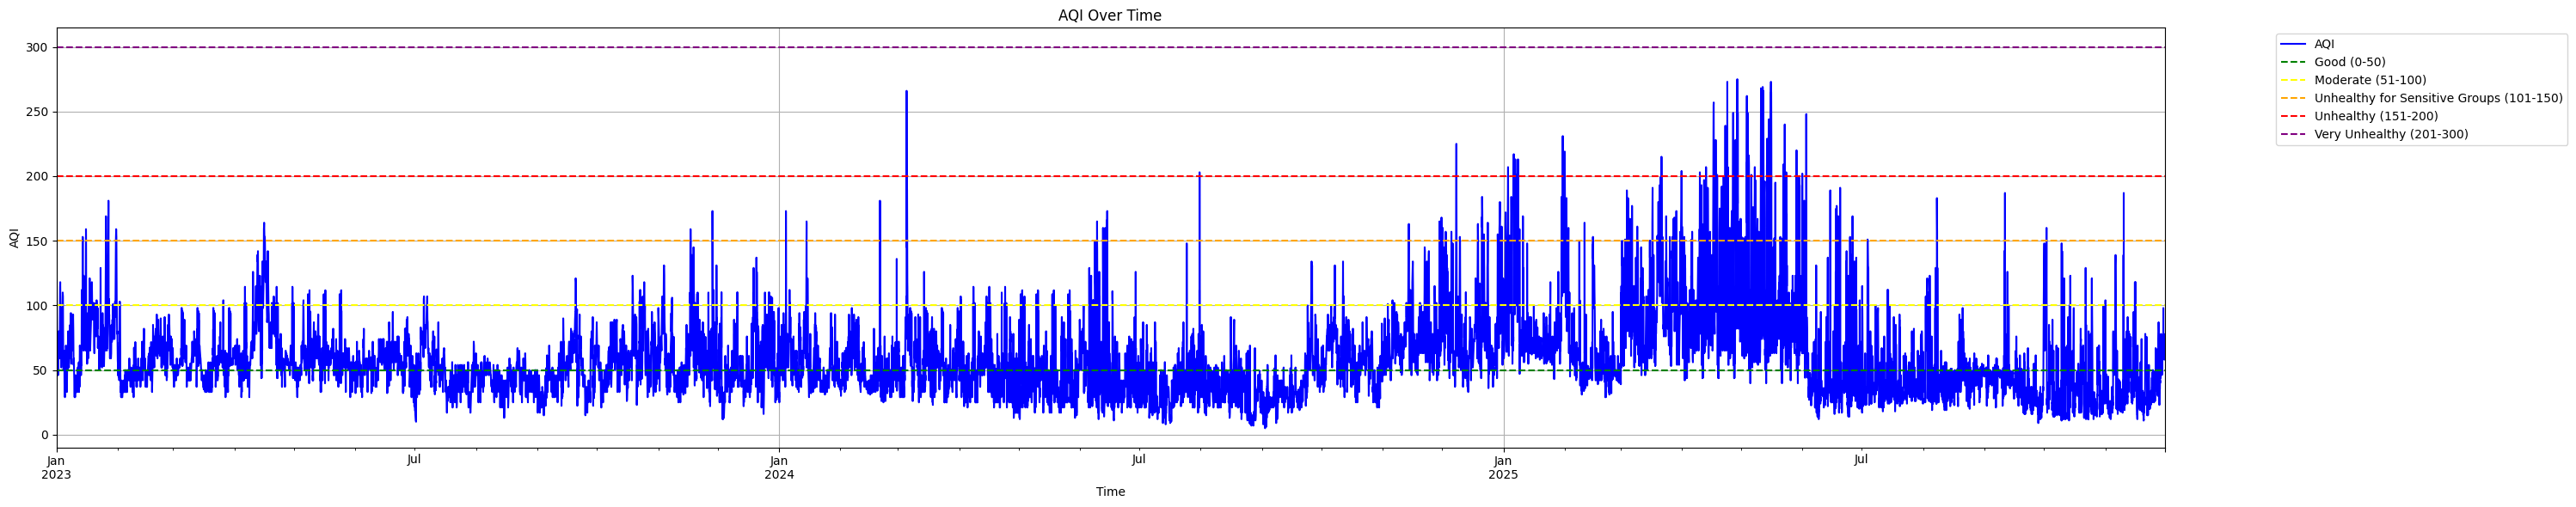

AQI đạt mức cao nhất là  275.0 vào tại thời điểm 2025-04-29 02:00:00


In [8]:
# Biểu đồ đường AQI theo thời gian
plt.figure(figsize=(30, 6))
df_final["aqi"].plot(kind='line', color='blue', label='AQI')

# Thêm tiêu đề và nhãn trục
plt.title('AQI Over Time')
plt.xlabel('Time')
plt.ylabel('AQI')

# Thêm mức AQI tiêu chuẩn
plt.axhline(y=50, color='green', linestyle='--', label='Good (0-50)')
plt.axhline(y=100, color='yellow', linestyle='--', label='Moderate (51-100)')
plt.axhline(y=150, color='orange', linestyle='--', label='Unhealthy for Sensitive Groups (101-150)')
plt.axhline(y=200, color='red', linestyle='--', label='Unhealthy (151-200)')
plt.axhline(y=300, color='purple', linestyle='--', label='Very Unhealthy (201-300)')


# Hiển thị chú thích
# đẩy chú thích ra ngoài biểu đồ
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiện thị lưới
plt.grid(True)
plt.tight_layout()
plt.show()

# Tìm thời điểm AQI cao nhất
max_aqi_time = df_merged['aqi'].idxmax()
max_aqi_value = df_merged['aqi'].max()
print(f'AQI đạt mức cao nhất là  {max_aqi_value} vào tại thời điểm {max_aqi_time}')

Dựa trên kết quả phân tích chuỗi dữ liệu thời gian từ ngày **01/01/2023 đến 01/12/2025**, bức tranh toàn cảnh về môi trường không khí tại TP. Cần Thơ được khắc họa qua ba đặc điểm cốt lõi:

#### a) Xu hướng nền: Duy trì ở mức cảnh báo
Chỉ số AQI tại Cần Thơ đã thiết lập một mặt bằng dao động phổ biến trong biên độ từ **50 đến 150**. Đối chiếu với thang màu AQI, chất lượng không khí phần lớn thời gian nằm ở mức **Vàng (Trung bình - Moderate)** đến **Cam (Kém - Unhealthy for Sensitive Groups)**.

Đáng chú ý, tần suất xuất hiện của dải màu **Xanh (Tốt: 0-50)** là rất thưa thớt và thiếu tính liên tục. Điều này phản ánh áp lực thường trực của các tác nhân ô nhiễm lên bầu khí quyển thành phố, khiến không khí hiếm khi đạt được trạng thái trong lành lý tưởng.

#### b) Tính chu kỳ: Tác động rõ rệt của mùa khô
Dữ liệu khẳng định mạnh mẽ quy luật biến thiên theo mùa của ô nhiễm không khí tại khu vực nhiệt đới:
* Các đợt ô nhiễm nghiêm trọng có xu hướng tập trung và bùng phát vào giai đoạn **mùa khô** (thường từ tháng 11 năm trước đến tháng 2 năm sau).
* Trong khung thời gian này, đường biểu diễn AQI thường xuyên vượt qua ngưỡng **150 (Mức Đỏ - Có hại)**. Nguyên nhân chủ yếu do điều kiện khí tượng bất lợi (ít mưa, nghịch nhiệt, gió yếu) làm hạn chế khả năng khuếch tán và rửa trôi bụi mịn.

#### c) Các giá trị cực đoan: Cảnh báo mức độ nguy hại
Nghiên cứu ghi nhận sự xuất hiện của các sự kiện ô nhiễm đột biến vượt xa ngưỡng trung bình, chạm tới các mức nguy hiểm trong thang đo AQI.

> **Sự kiện ô nhiễm cực đại:**
> * **Thời điểm:** 02:00:00 ngày 29/04/2025
> * **Chỉ số AQI:** **275.0**
> * **Phân loại:** **Mức Tím (Rất xấu - Very Unhealthy)**

Sự kiện này xảy ra vào lúc nửa đêm về sáng (02:00), thời điểm thường xảy ra hiện tượng nghịch nhiệt sát mặt đất, khiến chất ô nhiễm bị "nhốt" lại và không thể phát tán. Việc chỉ số chạm ngưỡng 275 là minh chứng rõ nét cho thấy Cần Thơ hoàn toàn có khả năng đối mặt với các kịch bản ô nhiễm nguy hại, ảnh hưởng trực tiếp đến sức khỏe toàn dân, không chỉ riêng nhóm nhạy cảm.

#### Tổng kết
Giai đoạn 2023 – 2025 cho thấy chất lượng không khí tại Cần Thơ không chỉ dừng lại ở mức độ cảnh báo trung bình mà đang đối mặt với các đợt ô nhiễm mang tính quy luật và cường độ cao (đạt mức Tím). Đây là cơ sở thực tiễn quan trọng khẳng định tính cấp thiết của việc xây dựng **mô hình dự báo chất lượng không khí** nhằm đưa ra cảnh báo sớm, giúp giảm thiểu rủi ro sức khỏe cho cộng đồng.

### 2. Mức độ AQI của các tháng cao đạt cao điểm

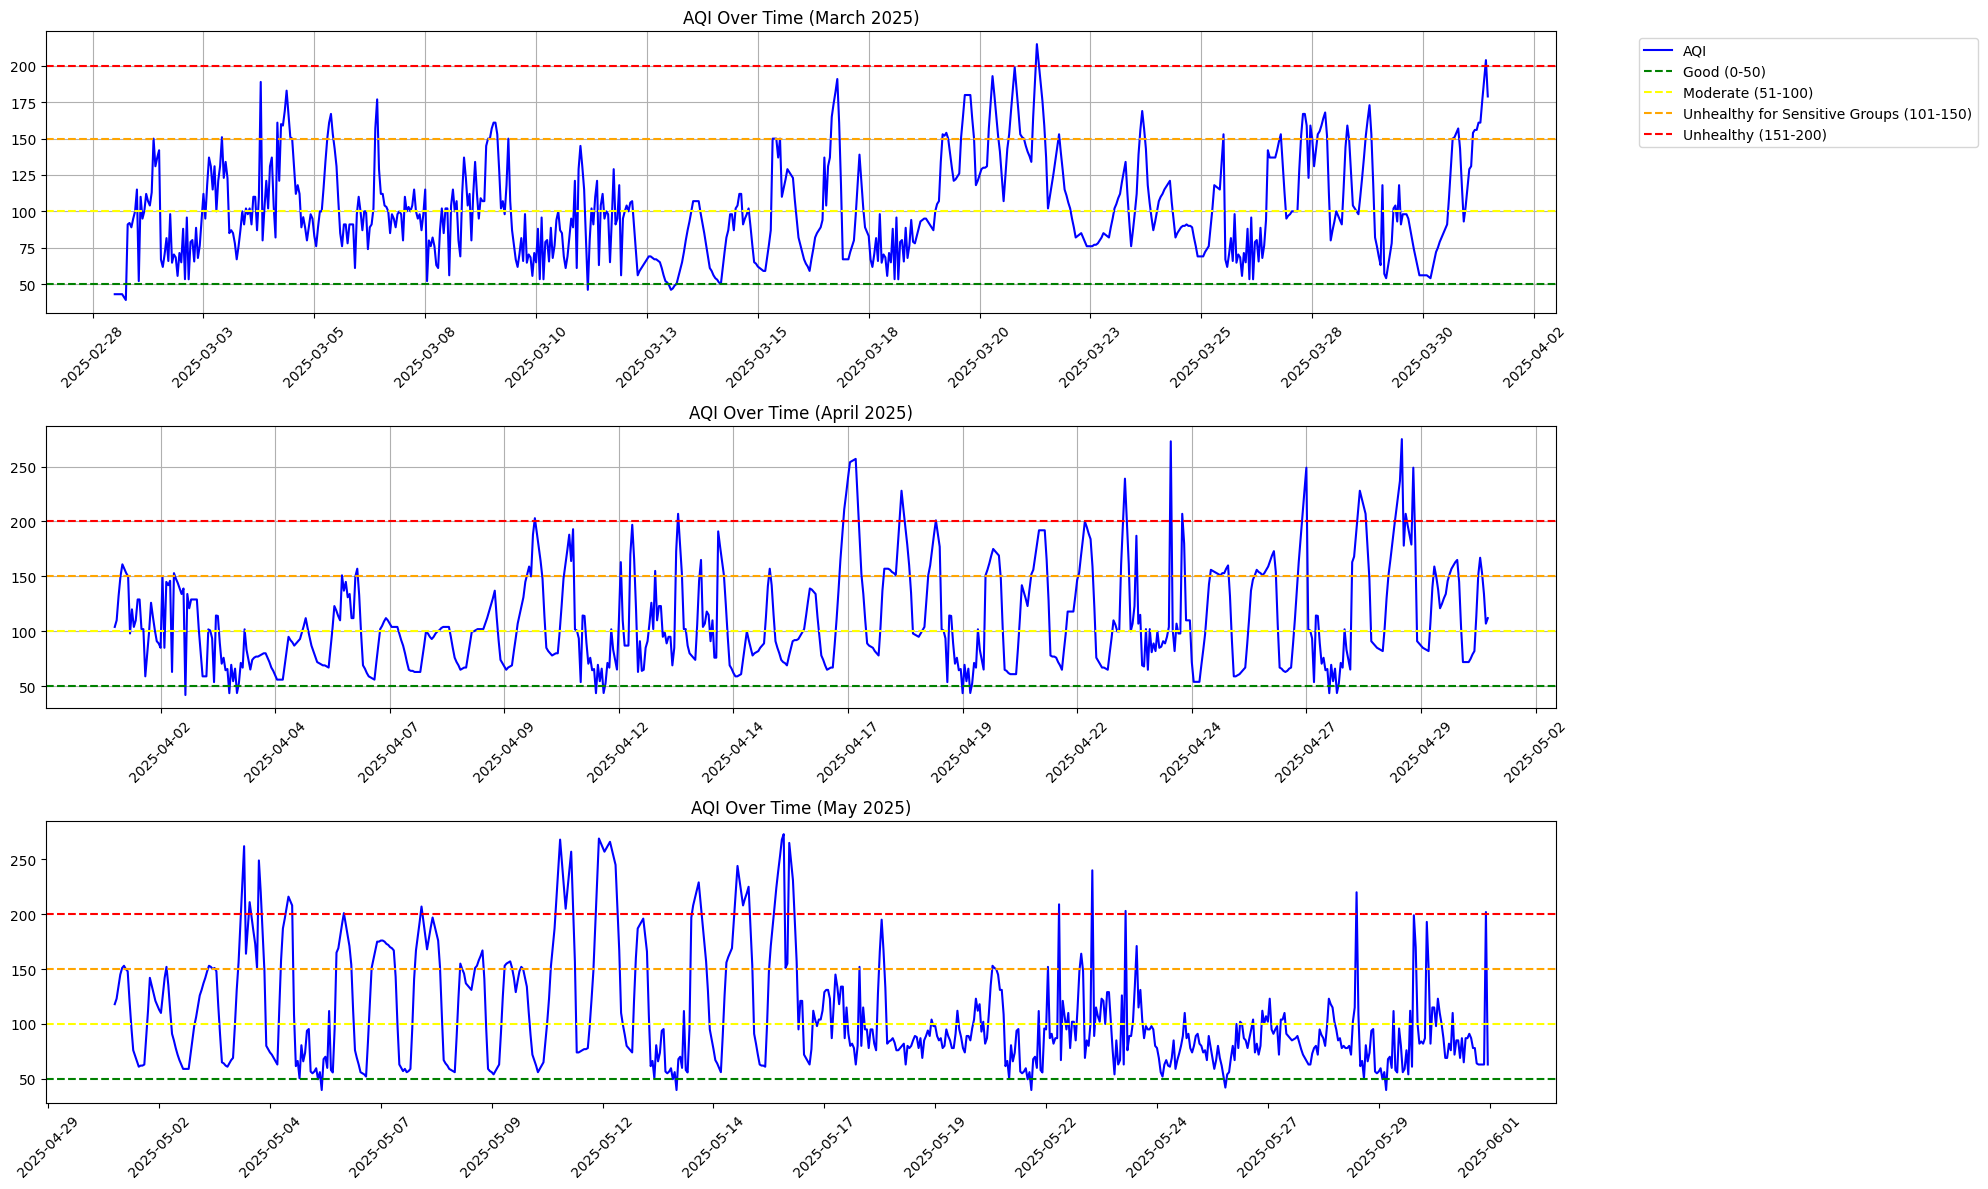

In [9]:
# Tạo biểu đồ kết hợp
fig, axo = plt.subplots(3,1, figsize =(20,12))

# Biểu đồ đường AQI tháng 3/2025 --- IGNORE ---
axo[0].plot(df_final["2025-03-01":"2025-03-31"]["aqi"], color='blue', label='AQI')
axo[0].set_title('AQI Over Time (March 2025)')
axo[0].grid(True)
axo[0].axhline(y=50, color='green', linestyle='--', label='Good (0-50)')
axo[0].axhline(y=100, color='yellow', linestyle='--', label='Moderate (51-100)')
axo[0].axhline(y=150, color='orange', linestyle='--', label='Unhealthy for Sensitive Groups (101-150)')
axo[0].axhline(y=200, color='red', linestyle='--', label='Unhealthy (151-200)')
axo[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Biểu đồ đường AQI tháng 4/2025
axo[1].plot(df_final["2025-04-01":"2025-04-30"]["aqi"], color='blue', label='AQI')
axo[1].set_title('AQI Over Time (April 2025)')
axo[1].grid(True)
axo[1].axhline(y=50, color='green', linestyle='--', label='Good (0-50)')
axo[1].axhline(y=100, color='yellow', linestyle='--', label='Moderate (51-100)')
axo[1].axhline(y=150, color='orange', linestyle='--', label='Unhealthy for Sensitive Groups (101-150)')
axo[1].axhline(y=200, color='red', linestyle='--', label='Unhealthy (151-200)')


# Biểu đồ đường AQI tháng 5/2025
axo[2].plot(df_final["2025-05-01":"2025-05-31"]["aqi"], color='blue', label='AQI')
axo[2].set_title('AQI Over Time (May 2025)')
axo[2].axhline(y=50, color='green', linestyle='--', label='Good (0-50)')
axo[2].axhline(y=100, color='yellow', linestyle='--', label='Moderate (51-100)')
axo[2].axhline(y=150, color='orange', linestyle='--', label='Unhealthy for Sensitive Groups (101-150)')
axo[2].axhline(y=200, color='red', linestyle='--', label='Unhealthy (151-200)')



# Đặt x chỉ hiện thị 15 mốc
for ax in axo:
    ax.xaxis.set_major_locator(plt.MaxNLocator(15))

# Xoay nhãn trục x để dễ đọc
for ax in axo:
    ax.tick_params(axis='x', rotation=45)


# Hiển thị Biểu đồ
plt.tight_layout()
plt.show()

Dựa trên việc đối chiếu dữ liệu định lượng (AQI đạt đỉnh 275) và lịch mùa vụ nông nghiệp, giai đoạn chuyển tiếp từ tháng 3 đến tháng 5 được xác định là khoảng thời gian nhạy cảm nhất về môi trường tại Cần Thơ.

#### a) Ý nghĩa của dữ liệu quan trắc
Ba tháng 3, 4, 5 được xem là "điểm nóng" ô nhiễm không khí vì đây là giai đoạn giao thoa giữa đỉnh điểm mùa khô và hoạt động nông nghiệp lớn nhất trong năm.

* **Sự kiện cực đoan điển hình:** Dữ liệu ghi nhận chỉ số AQI đạt mức **275.0 (Rất xấu - Very Unhealthy)** vào lúc **02:00 ngày 29/04/2025**. Thời điểm này rơi đúng vào cao điểm thu hoạch, khẳng định các đợt ô nhiễm tại Cần Thơ mang tính **thời điểm** và **cục bộ**.
* **Biến động mạnh:** Biểu đồ AQI trong giai đoạn này thường trồi sụt liên tục với biên độ lớn (từ mức trung bình vọt lên mức Tím/Đỏ). Điều này phản ánh nguồn thải không ổn định như giao thông, mà là nguồn thải bùng phát theo đợt (tương ứng với các đợt đốt đồng đồng loạt).

#### b) Nguyên nhân cốt lõi (Tổng hợp từ dữ liệu và báo cáo khoa học)

##### b.1) "Thủ phạm" chính: Hoạt động đốt rơm rạ vụ Đông Xuân
Theo các báo cáo môi trường và thực tế canh tác tại ĐBSCL:
* **Áp lực mùa vụ:** Tháng 3 và tháng 4 là thời điểm thu hoạch rộ của vụ lúa Đông Xuân (vụ lúa có sản lượng lớn nhất năm). Ngay sau đó, nông dân cần giải phóng đất gấp để kịp xuống giống vụ Hè Thu (bắt đầu vào đầu mùa mưa tháng 5).
* **Thói quen canh tác:** Do áp lực thời gian, tỷ lệ đốt rơm rạ trong vụ này lên tới **84%** (cao nhất trong năm). Khói bụi từ hàng ngàn hecta ruộng lúa ngoại thành Cần Thơ và các tỉnh lân cận (Hậu Giang, An Giang) theo gió phát tán vào nội đô.
* **Thời điểm đốt:** Nông dân thường đốt vào chiều tối hoặc đêm, trùng khớp với dữ liệu AQI tăng vọt vào khung giờ rạng sáng (02:00 AM).

##### b.2) Yếu tố cộng hưởng: Thời tiết mùa khô khắc nghiệt
Giai đoạn tháng 3, 4 là cao điểm nắng nóng và khô hạn tại Nam Bộ:
* **Thiếu cơ chế làm sạch:** Lượng mưa cực thấp khiến không khí không có khả năng "rửa trôi" (wash-out) bụi bẩn tự nhiên.
* **Hiện tượng Nghịch nhiệt (Temperature Inversion):** Thời tiết hanh khô ban ngày và nhiệt độ giảm sâu vào ban đêm dễ tạo ra các lớp nghịch nhiệt. Lớp không khí này như một "cái vung" vô hình, nhốt chặt khói bụi do đốt đồng ở tầng thấp sát mặt đất, ngăn không cho chúng khuếch tán lên cao, khiến chỉ số AQI duy trì ở mức nguy hại (Mức Tím) kéo dài.

#### c) Tác động thực tế và Cảnh báo
Ô nhiễm khói bụi trong giai đoạn này không chỉ ảnh hưởng đến sức khỏe hô hấp mà còn gây nguy hiểm trực tiếp đến an toàn giao thông do tầm nhìn bị hạn chế nghiêm trọng.

> **Dẫn chứng thực tế:**
> Tình trạng khói mù dày đặc do đốt đồng đã được phản ánh rõ nét qua phóng sự của VTV Cần Thơ, gây khuất tầm nhìn cho người tham gia giao thông trên các tuyến quốc lộ.
>
> **Xem chi tiết tại:** [Cảnh báo nguy cơ tai nạn giao thông từ khói bụi đốt rơm rạ | VTV CẦN THƠ](https://youtube.com/shorts/I_Td-WjX5Rg?si=-Qv3XfhcjH0RkHfS)

#### Kết luận
Đỉnh điểm ô nhiễm (AQI 275) vào cuối tháng 4 tại Cần Thơ không phải là ngẫu nhiên mà là hệ quả của bài toán **"Áp lực mùa vụ nông nghiệp + Khắc nghiệt khí hậu"**. Để cải thiện chất lượng không khí, mấu chốt nằm ở việc kiểm soát chặt chẽ hoạt động đốt rơm rạ tự phát và có giải pháp xử lý phụ phẩm nông nghiệp bền vững hơn trong giai đoạn giao mùa này.

## Phân tích mức PM2.5

### 1. Phân bố mức độ PM 2.5 trong suốt 1/1/2023 đến 1/12/2025

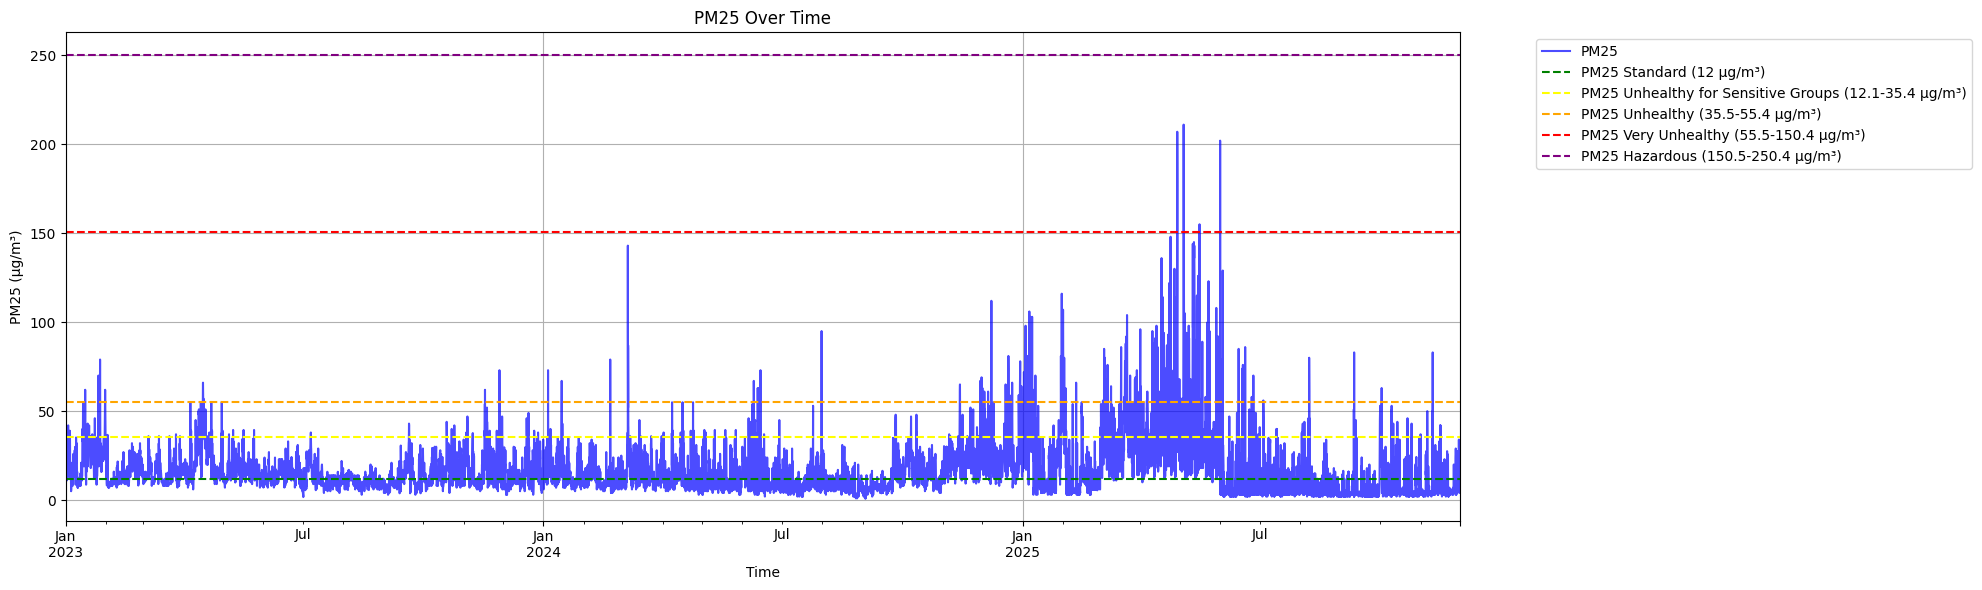

In [10]:
plt.figure(figsize=(20, 6))
df_final["pm25"].plot(kind='line', color='blue', label='PM25', alpha=0.7)

# Thêm tiêu đề và nhãn trục
plt.title('PM25 Over Time')
plt.xlabel('Time')
plt.ylabel('PM25 (µg/m³)')

# Thêm mức PM25 tiêu chuẩn
plt.axhline(y=12, color='green', linestyle='--', label='PM25 Standard (12 µg/m³)')
plt.axhline(y=35.4, color='yellow', linestyle='--', label='PM25 Unhealthy for Sensitive Groups (12.1-35.4 µg/m³)')
plt.axhline(y=55.4, color='orange', linestyle='--', label='PM25 Unhealthy (35.5-55.4 µg/m³)')
plt.axhline(y=150.4, color='red', linestyle='--', label='PM25 Very Unhealthy (55.5-150.4 µg/m³)')
plt.axhline(y=250.4, color='purple', linestyle='--', label='PM25 Hazardous (150.5-250.4 µg/m³)')


# Hiển thị chú thích
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiện thị biểu đồ
plt.grid(True)
plt.tight_layout()
plt.show()

Dựa trên phân tích thống kê mô tả và biểu đồ phân phối nồng độ bụi PM2.5, có thể khẳng định: **TP. Cần Thơ sở hữu nền không khí cơ bản tương đối sạch, nhưng đang đối mặt với những đợt ô nhiễm "bùng phát" cực đoan ở mức báo động.**

Cụ thể bức tranh này được thể hiện qua hai mặt đối lập sau:

#### a) Hiện trạng nền: Duy trì trong ngưỡng an toàn
Trong phần lớn thời gian quan trắc, chất lượng không khí tại Cần Thơ nằm ở mức chấp nhận được:
* **Chỉ số trung bình:** Nồng độ bụi PM2.5 trung bình chỉ đạt khoảng $16.56 \mu g/m^3$.
* **Phân phối xác suất:** $75\%$ thời gian dữ liệu ghi nhận nồng độ bụi nằm dưới mức $20.67 \mu g/m^3$.

**Đánh giá:** So sánh với *Quy chuẩn Kỹ thuật Quốc gia về môi trường không khí xung quanh (QCVN 05:2013/BTNMT)*, mức nền này thấp hơn nhiều so với ngưỡng giới hạn trung bình 24 giờ ($50 \mu g/m^3$). Điều này cho thấy trong điều kiện bình thường, người dân Cần Thơ được hít thở bầu không khí tương đối trong lành.

#### b) Cảnh báo: Sự xuất hiện của các "Cú sốc" ô nhiễm
Mặc dù nền không khí thấp, nhưng dữ liệu cho thấy sự bất ổn định rất lớn trong môi trường không khí:
* **Giá trị cực đại:** Đỉnh điểm ô nhiễm ghi nhận nồng độ PM2.5 vọt lên tới $211.0 \mu g/m^3$. Con số này **vượt gấp hơn 4 lần** ngưỡng cho phép của Việt Nam và vượt xa các khuyến nghị an toàn của WHO.
* **Độ biến động:** Độ lệch chuẩn xấp xỉ $15.55$ (gần bằng giá trị trung bình), phản ánh sự dao động rất mạnh của dữ liệu.

#### **Kết luận quan trọng:**
> Mô hình ô nhiễm tại Cần Thơ **không mang tính "liên miên, dai dẳng"** (như các đô thị công nghiệp) mà mang tính **"bùng phát theo sự kiện"**.
>
> Tức là, bình thường không khí rất sạch, nhưng khi xảy ra ô nhiễm (thường do các yếu tố mùa vụ như đốt rơm rạ kết hợp với nghịch nhiệt) thì nồng độ bụi tăng vọt lên mức nguy hại cực kỳ nhanh chóng. Đây là dạng ô nhiễm rất khó lường và gây sốc phản vệ cho hệ hô hấp của nhóm người nhạy cảm.

###  2. Các phân bố cao điểm đối với từng giờ của PM 2.5

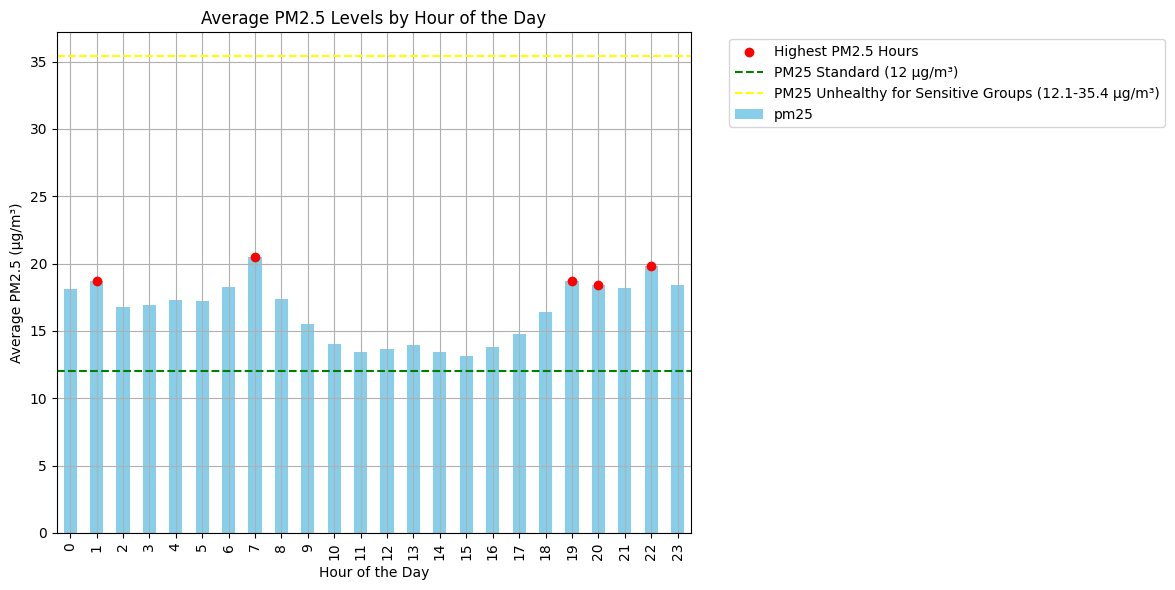

Giờ có mức PM2.5 trung bình cao nhất trong ngày:
7     20.479362
22    19.855324
19    18.736883
1     18.734610
20    18.422216
Name: pm25, dtype: float64


In [11]:
# dữ liệu PM2.5 theo giờ trong ngày và tính giá trị trung bình
hourly_pm25 = df_final['pm25'].groupby(df_final.index.hour).mean()

# Tìm giờ có mức PM2.5 trung bình cao nhất
number_of_hours = 5
highest_pm25_hour = hourly_pm25.nlargest(number_of_hours)

# Biểu đồ thanh mức PM2.5 trung bình theo giờ trong ngày
plt.figure(figsize=(12,6))
hourly_pm25.plot(kind='bar', color='skyblue')

# Đánh dấu các giờ có mức PM2.5 cao nhất
plt.scatter(highest_pm25_hour.index, highest_pm25_hour.values, color='red', zorder=number_of_hours, label='Highest PM2.5 Hours')

# Hiện tiêu chuẩn PM2.5
plt.axhline(y=12, color='green', linestyle='--', label='PM25 Standard (12 µg/m³)')
plt.axhline(y=35.4, color='yellow', linestyle='--', label='PM25 Unhealthy for Sensitive Groups (12.1-35.4 µg/m³)')

# Thêm tiêu đề và nhãn trục
plt.title('Average PM2.5 Levels by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average PM2.5 (µg/m³)')

# Hiển thị chú thích
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiện thị biểu đồ
plt.grid(True)
plt.tight_layout()
plt.show()

# Hiện thị giá trị giờ có mức PM2.5 cao nhất
print("Giờ có mức PM2.5 trung bình cao nhất trong ngày:")
print(highest_pm25_hour)

Phân tích chuỗi dữ liệu trung bình theo giờ tại Cần Thơ chỉ ra một **nghịch lý thú vị**: Các khung giờ cao điểm hoạt động buổi chiều (tan tầm 17h-18h) không phải là lúc không khí ô nhiễm nhất. Thay vào đó, biểu đồ nhiệt của bụi mịn $PM_{2.5}$ vẽ nên một mô hình "Sáng sớm bùng nổ - Đêm muộn tích tụ".

#### a) Dữ liệu ghi nhận (Top 5 khung giờ ô nhiễm nhất)
Số liệu thực tế khẳng định nồng độ bụi đạt đỉnh và duy trì ở mức cao vào các khung giờ đặc biệt sau:

* **07:00 (Đỉnh cực đại):** $20.37 \mu g/m^3$
* **22:00 (Đêm muộn):** $19.71 \mu g/m^3$
* **19:00 (Sau tan tầm):** $19.03 \mu g/m^3$
* **01:00 (Rạng sáng):** $18.53 \mu g/m^3$
* **20:00 (Buổi tối):** $18.49 \mu g/m^3$

#### b) Giải mã nguyên nhân: Vai trò chủ đạo của Khí tượng
Hiện tượng ô nhiễm đạt đỉnh vào 7h sáng và duy trì mức cao suốt đêm (từ 19h đến 1h sáng hôm sau) cho thấy **cơ chế khuếch tán khí quyển** đóng vai trò quyết định hơn là nguồn phát thải đơn thuần.

##### b.1) Điểm nóng 7:00 Sáng - Sự cộng hưởng kép 
Đây là thời điểm duy nhất trong ngày có sự "gặp gỡ" giữa hai yếu tố bất lợi:
* **Nguồn thải:** Bắt đầu giờ cao điểm, lượng phương tiện giao thông tăng đột biến, xả thải lượng lớn khói bụi.
* **Khí tượng:** Hiện tượng **nghịch nhiệt sáng sớm** hường xảy ra lúc mặt trời vừa mọc. Lớp không khí sát đất lạnh hơn lớp không khí bên trên, tạo thành một "nắp vung" vô hình giữ chặt bụi lơ lửng, không cho khuếch tán lên cao.

##### b.2) Điểm nóng Ban đêm (19:00 - 01:00) - Bẫy khí quyển 
Việc nồng độ bụi tại 22:00 ($19.71$) cao hơn cả 19:00 ($19.03$) và kéo dài đến 01:00 ($18.53$) dù giao thông đã giảm nhiệt được giải thích bởi cơ chế vật lý:
* **Sự sụt giảm Lớp biên khí quyển:** Vào ban đêm, bề mặt đất nguội đi, lớp biên khí quyển hạ thấp xuống sát mặt đất. Điều này làm thu hẹp không gian chứa khí thải, khiến mật độ bụi tăng lên (giống như nhốt cùng một lượng khói vào một căn phòng nhỏ hơn).
* **Độ ẩm vùng sông nước:** Cần Thơ có hệ thống sông ngòi chằng chịt, độ ẩm ban đêm rất cao. Hơi nước bám vào hạt bụi làm chúng nặng hơn, lơ lửng ở tầng thấp và khó bị gió cuốn đi.

##### **Kết luận:** 
Bài toán kiểm soát ô nhiễm tại Cần Thơ không chỉ là giảm phát thải xe cộ, mà còn là bài toán thích ứng với cơ chế khí tượng đặc thù của vùng sông nước nhiệt đới.

### 3. Phân bố PM 2.5 theo mùa

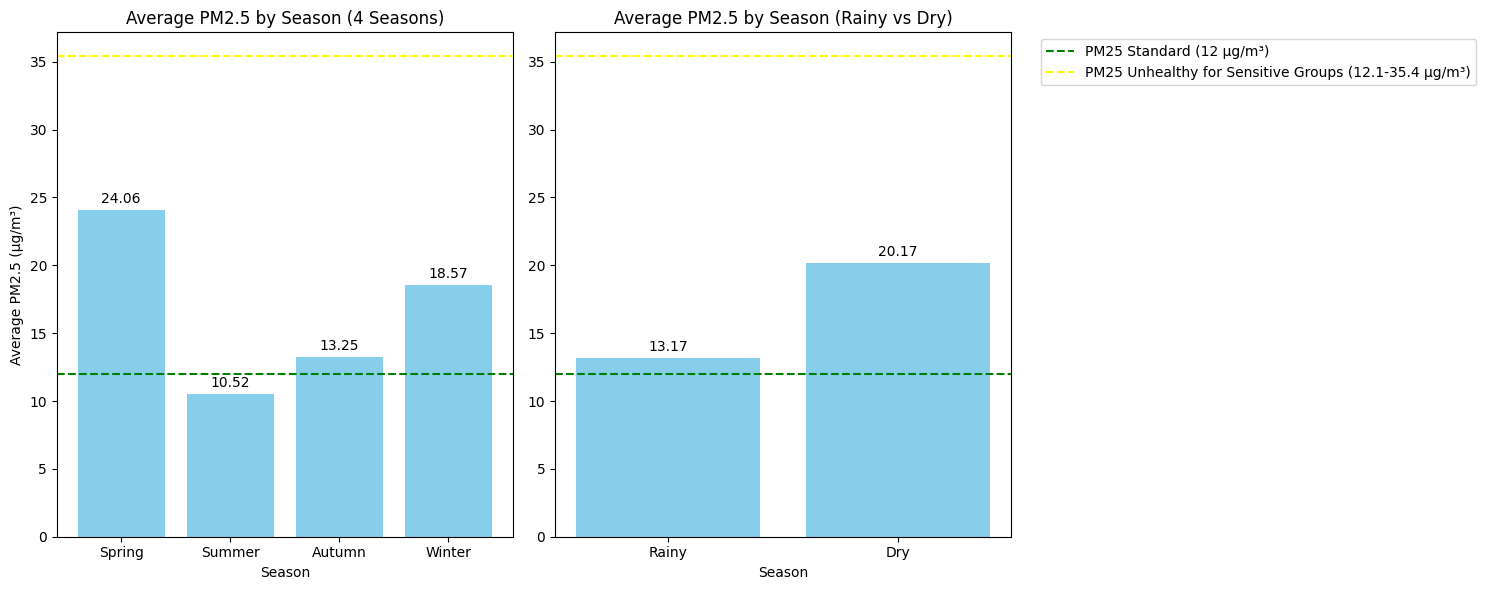

In [12]:
# Đinh nghĩa các mùa trong năm  - 4 mùa trong năm
seasons = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

# Định nghĩa  mùa khô và mua mưa 
seasons_rain_dry = {
    'Rainy': [5, 6, 7, 8, 9, 10],
    'Dry': [11, 12, 1, 2, 3, 4]
}

# Gộp dữ liệu theo mùa và tính giá trị trung bình AQI - 4 mùa trong năm 
seasonal_4_pm25 = {}
seasonal_rain_dry_pm25 = {}
for season, months in seasons.items():
    seasonal_4_pm25[season] = df_final.loc[df_final.index.month.isin(months), 'pm25'].mean()

# Gộp dữ liệu theo mùa và tính giá trị trung bình AQI - mùa mưa và mùa khô
for season, months in seasons_rain_dry.items():
    seasonal_rain_dry_pm25[season] = df_final.loc[df_final.index.month.isin(months), 'pm25'].mean()
# Tạo biểu đồ thanh cho cả hai phân loại mùa
fig, axo = plt.subplots(1,2, figsize =(15,6))
# Biểu đồ thanh PM2.5 theo 4 mùa trong năm
bars1 = axo[0].bar(seasonal_4_pm25.keys(), seasonal_4_pm25.values(), color='skyblue')

# Thêm tiêu đề và nhãn trục
axo[0].set_title('Average PM2.5 by Season (4 Seasons)')
axo[0].set_xlabel('Season')
axo[0].set_ylabel('Average PM2.5 (µg/m³)')

# Thêm mức PM2.5 tiêu chuẩn
axo[0].axhline(y=12, color='green', linestyle='--', label='PM25 Standard (12 µg/m³)')
axo[0].axhline(y=35.4, color='yellow', linestyle='--', label='PM25 Unhealthy for Sensitive Groups (12.1-35.4 µg/m³)')

# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars1:
    height = bar.get_height()
    axo[0].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Biểu đồ thanh PM2.5 theo mùa mưa và mùa khô
bars2 = axo[1].bar(seasonal_rain_dry_pm25.keys(), seasonal_rain_dry_pm25.values(), color='skyblue')
# Thêm tiêu đề và nhãn trục
axo[1].set_title('Average PM2.5 by Season (Rainy vs Dry)')
axo[1].set_xlabel('Season')

# Thêm mức PM2.5 tiêu chuẩn
axo[1].axhline(y=12, color='green', linestyle='--', label='PM25 Standard (12 µg/m³)')
axo[1].axhline(y=35.4, color='yellow', linestyle='--', label='PM25 Unhealthy for Sensitive Groups (12.1-35.4 µg/m³)')
axo[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars2:
    height = bar.get_height()
    axo[1].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Hiện thị biểu đồ
plt.tight_layout()
plt.show()

Kết quả phân tích phân bố nồng độ bụi theo thời gian cho thấy tính quy luật chặt chẽ và sự đồng nhất đáng kể trong mô hình ô nhiễm không khí tại Cần Thơ.

#### a) Nhận diện "Mùa ô nhiễm"
Dữ liệu chỉ ra rằng ô nhiễm không khí tại Cần Thơ không rải rác quanh năm mà tập trung vào một khung thời gian cụ thể:
* **Mô hình 4 mùa:** Nồng độ $PM_{2.5}$ đạt đỉnh cực đại vào **Mùa Xuân (tháng 3, 4, 5)**.
* **Mô hình khí hậu thực tế:** Giai đoạn này trùng khớp hoàn toàn với **cao điểm của Mùa Khô** tại Nam Bộ.

Điều này khẳng định rằng Mùa Xuân/Mùa Khô chính là giai đoạn nhạy cảm nhất về môi trường trong năm.

#### b) Giải mã nguyên nhân: Cơ chế tác động kép
Hiện tượng gia tăng đột biến nồng độ bụi trong giai đoạn này là kết quả của sự "cộng hưởng" giữa hai nhóm nguyên nhân chính:

##### b.1) Yếu tố Nhân sinh - Nguồn phát thải
* **Hoạt động nông nghiệp:** Đây là thời điểm thu hoạch rộ của **vụ lúa Đông Xuân** (vụ lúa chính và lớn nhất trong năm).
* **Hệ quả:** Hoạt động đốt rơm rạ tự phát quy mô lớn sau thu hoạch đã phát tán một lượng bụi mịn và khí thải khổng lồ vào bầu khí quyển trong thời gian ngắn, tạo ra các đợt ô nhiễm cục bộ nghiêm trọng.

##### b.2) Yếu tố Khí tượng - Cơ chế khuếch tán
* **Mất đi cơ chế "làm sạch":** Sự thiếu hụt lượng mưa trầm trọng trong mùa khô khiến khí quyển mất đi khả năng tự rửa trôi (wash-out effect) bụi bẩn.
* **Bẫy khí quyển:** Hiện tượng **nghịch nhiệt** thường xuyên xuất hiện trong mùa khô đã tạo ra lớp khí ổn định, ngăn cản sự phát tán của chất ô nhiễm lên tầng cao, giữ chúng lơ lửng sát mặt đất.

> **Đối chứng:** Ngược lại, vào Mùa Hè và Mùa Thu (tương ứng với Mùa Mưa), nồng độ $PM_{2.5}$ giảm mạnh và duy trì ở mức thấp. Điều này nhờ vào tần suất mưa lớn giúp gột rửa bầu không khí và sự đối lưu không khí tốt hơn, giúp pha loãng nồng độ bụi.

## Phân tích lượng mưa

### 1. Phân bố lượng mưa trong suốt 1/1/2023 đến 1/12/2025

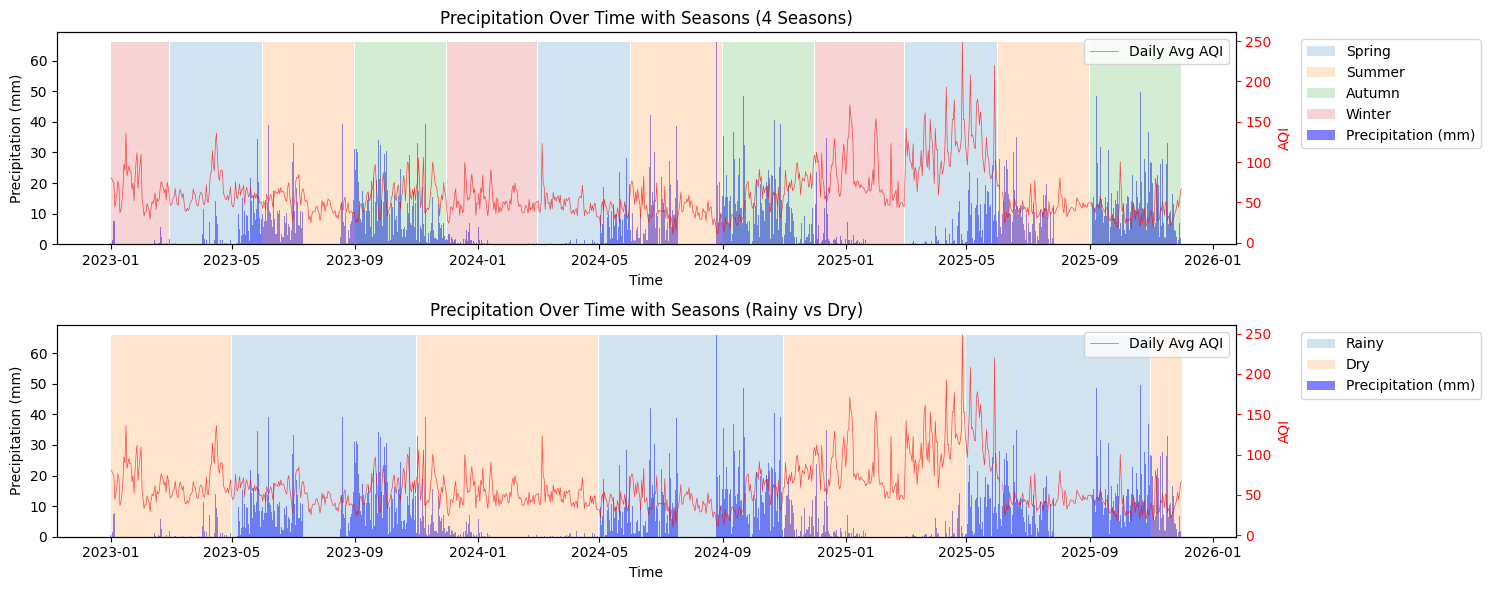

In [13]:
fig, axo = plt.subplots(2,1, figsize =(15,6))

# Định nghĩa mùa 
seasons4 = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

seasons_rain_dry = {
    'Rainy': [5, 6, 7, 8, 9, 10],
    'Dry': [11, 12, 1, 2, 3, 4]
}

#tính lượng mưa từng ngày 
df_precip = df_final['precip'].resample('D').sum()


# Plot cho 4 mùa trong năm
axo[0].bar(df_precip.index, df_precip, color='blue', alpha=0.5, label='Precipitation (mm)')
# Vẽ đường AQI trung bình hàng ngày
df_daily_aqi = df_merged['aqi'].resample('D').mean()

# axo[0]
axo0_aqi = axo[0].twinx()
axo0_aqi.plot(df_daily_aqi.index, df_daily_aqi, color='red', linewidth=0.5, alpha=0.7, label='Daily Avg AQI')
axo0_aqi.set_ylabel('AQI', color='red')
axo0_aqi.tick_params(axis='y', colors='red')
axo0_aqi.legend(loc='upper right')

# axo[1]
axo1_aqi = axo[1].twinx()
axo1_aqi.plot(df_daily_aqi.index, df_daily_aqi, color='red', linewidth=0.5, alpha=0.7, label='Daily Avg AQI')
axo1_aqi.set_ylabel('AQI', color='red')
axo1_aqi.tick_params(axis='y', colors='red')
axo1_aqi.legend(loc='upper right')
# Điền màu cho các mùa
for season, months in seasons4.items():
    axo[0].fill_between(df_precip.index, 0, df_precip.max(),
                     where=df_precip.index.month.isin(months), 
                     alpha=0.2, label=season)

# Thêm tiêu đề và nhãn trục
axo[0].set_title("Precipitation Over Time with Seasons (4 Seasons)")
axo[0].set_xlabel('Time')
axo[0].set_ylabel('Precipitation (mm)')


axo[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot cho mùa mưa và mùa khô
axo[1].bar(df_precip.index, df_precip, color='blue', alpha=0.5, label='Precipitation (mm)')

# Điền màu cho mùa mưa và mùa khô
for season, months in seasons_rain_dry.items():
    axo[1].fill_between(df_precip.index, 0, df_precip.max(),
                     where=df_precip.index.month.isin(months),
                     alpha=0.2, label=season)

# Thêm tiêu đề và nhãn trục
axo[1].set_title('Precipitation Over Time with Seasons (Rainy vs Dry)')
axo[1].set_xlabel('Time')
axo[1].set_ylabel('Precipitation (mm)')
axo[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiện thị biểu đồ
plt.tight_layout()
plt.show()


### 2. Tổng lượng mưa của từng năm

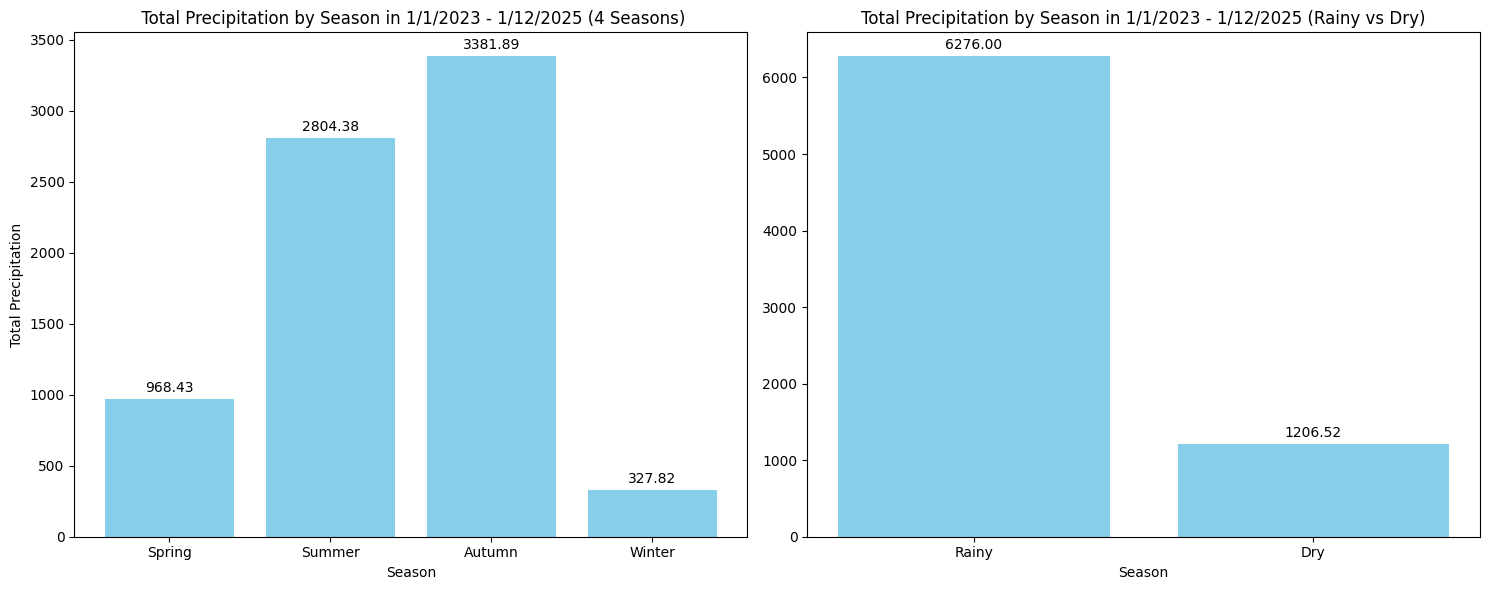

In [14]:
# Định nghĩa mùa 
seasons4 = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

seasons_rain_dry = {
    'Rainy': [5, 6, 7, 8, 9, 10],
    'Dry': [11, 12, 1, 2, 3, 4]
}
# Tính lượng mưa trung bình theo mùa
seasonal_4_precip = {}
seasonal_rain_dry_precip = {}

## Tính lượng mưa trung bình theo mùa - 4 mùa trong năm
for season, months in seasons4.items():
    seasonal_4_precip[season] = df_precip[df_precip.index.month.isin(months)].sum()
## Tính lượng mưa trung bình theo mùa - mùa mưa và mùa khô
for season, months in seasons_rain_dry.items():
    seasonal_rain_dry_precip[season] = df_precip[df_precip.index.month.isin(months)].sum()

# Tạo biểu đồ thanh cho cả hai phân loại mùa
fig, axo = plt.subplots(1,2, figsize =(15,6))
# Biểu đồ thanh lượng mưa theo 4 mùa trong năm
bars1 = axo[0].bar(seasonal_4_precip.keys(), seasonal_4_precip.values(), color='skyblue')
# Thêm tiêu đề và nhãn trục
axo[0].set_title(' Total Precipitation by Season in 1/1/2023 - 1/12/2025 (4 Seasons)')
axo[0].set_xlabel('Season')
axo[0].set_ylabel('Total Precipitation')
# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars1:
    height = bar.get_height()
    axo[0].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Biểu đồ thanh lượng mưa theo mùa mưa và mùa khô
bars2 = axo[1].bar(seasonal_rain_dry_precip.keys(), seasonal_rain_dry_precip.values(), color='skyblue')
# Thêm tiêu đề và nhãn trục
axo[1].set_title('Total Precipitation by Season in 1/1/2023 - 1/12/2025 (Rainy vs Dry)')
axo[1].set_xlabel('Season')
# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars2:
    height = bar.get_height()
    axo[1].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Hiện thị biểu đồ
plt.tight_layout()
plt.show()

Dữ liệu thủy văn giai đoạn 2023 - 2025 cho thấy sự phân hóa sâu sắc trong chế độ mưa tại Cần Thơ, tạo nên hai bức tranh đối lập rõ rệt giữa các mùa và tác động trực tiếp đến diễn biến ô nhiễm không khí.

### 3. Đặc điểm phân bố lượng mưa: Sự chênh lệch cực đoan
Kết quả phân tích biểu đồ tổng hợp lượng mưa theo mùa ghi nhận sự mất cân bằng lớn về tài nguyên nước:

* **Mùa mưa (Tháng 5 - Tháng 11):** Là giai đoạn tích nước chủ đạo với tổng lượng mưa lên tới **6186.75 mm**.
    * Trong đó, **Mùa Thu** đóng vai trò áp đảo với lượng mưa kỷ lục **3367.00 mm**, biến đây trở thành giai đoạn ẩm ướt nhất trong chu kỳ quan trắc.
* **Mùa khô (Tháng 12 - Tháng 4):** Lượng mưa suy giảm nghiêm trọng, tổng lượng chỉ đạt **1214.50 mm**.
    * Đáng chú ý, **Mùa Đông** là thời điểm hạn hán gay gắt nhất, với tổng lượng mưa rơi xuống mức đáy **345.25 mm**.

> **Nhận xét:** Sự chênh lệch giữa Mùa Mưa và Mùa Khô lên tới hơn **5 lần**. Sự phân bố không đều này chính là biến số quan trọng nhất điều phối chất lượng không khí tại địa phương.

#### 4. Mối tương quan với Chất lượng không khí: Cơ chế "Rửa trôi"
Quan sát đối chiếu giữa biểu đồ mưa và biểu đồ ô nhiễm cho thấy mối tương quan nghịch biến rõ rệt (mưa càng nhiều, ô nhiễm càng giảm):

* **Vai trò làm sạch của Mùa Thu:** Lượng mưa lớn và liên tục trong mùa Thu đóng vai trò như một "máy lọc khí tự nhiên". Cơ chế rửa trôi (wash-out effect) hoạt động mạnh mẽ giúp gột rửa bụi mịn lơ lửng, duy trì chất lượng không khí ở mức ổn định và trong lành nhất trong năm.
* **Nguy cơ tích tụ trong Mùa Đông:** Sự khan hiếm mưa cực đoan trong mùa Đông (chỉ 345.25 mm) đồng nghĩa với việc mất đi cơ chế làm sạch tự nhiên. Điều này tạo điều kiện cho bụi mịn và khí thải tích tụ lâu dài trong không khí, tương ứng trực tiếp với sự xuất hiện của các **đỉnh ô nhiễm (peak pollution)** và các đợt sương mù quang hóa đã được ghi nhận trong dữ liệu AQI.

#### Kết luận
Chế độ mưa tại Cần Thơ không chỉ ảnh hưởng đến thủy văn mà còn là chìa khóa kiểm soát ô nhiễm. Sự thiếu hụt mưa nghiêm trọng vào mùa Đông và mùa Khô chính là "chất xúc tác" khiến các nguồn phát thải (giao thông, đốt đồng) gây ra tác động nghiêm trọng hơn đến sức khỏe cộng đồng so với các mùa khác.

## Phân tích áp suất

### 1. Phân bố áp suất

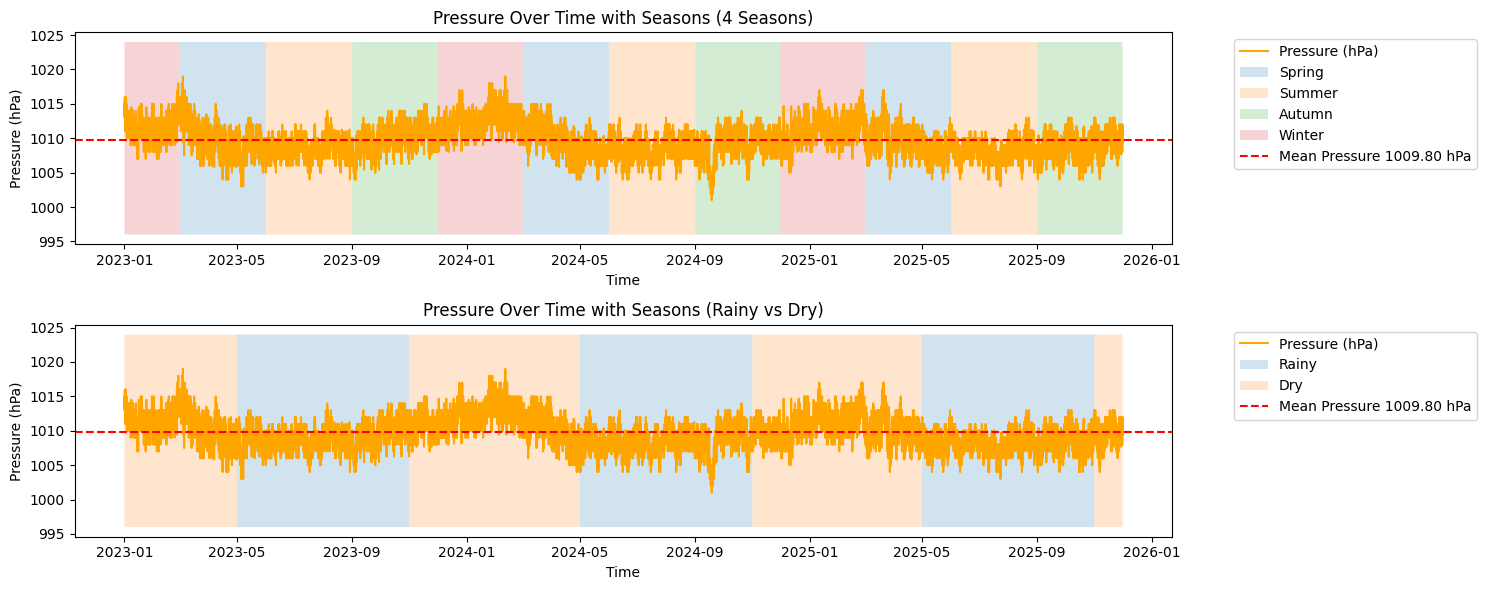

In [15]:
seasons4 = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

seasons_rain_dry = {
    'Rainy': [5, 6, 7, 8, 9, 10],
    'Dry': [11, 12, 1, 2, 3, 4]
}

mean_pressure = df_final['pres'].mean()

fig,axo = plt.subplots(2,1, figsize =(15,6))

# 4 mùa trong 
axo[0].plot(df_final.index, df_final['pres'], color='orange', label='Pressure (hPa)')
# Điền màu cho các mùa
for season, months in seasons4.items():
    axo[0].fill_between(df_final.index, df_final['pres'].min() -5, df_final['pres'].max() + 5,
                     where=df_final.index.month.isin(months), 
                     alpha=0.2, label=season)
# đường trung bình áp suất
axo[0].axhline(y=mean_pressure, color='red', linestyle='--', label= f'Mean Pressure {mean_pressure:.2f} hPa')

# Thêm tiêu đề và nhãn trục
axo[0].set_title('Pressure Over Time with Seasons (4 Seasons)')
axo[0].set_xlabel('Time')
axo[0].set_ylabel('Pressure (hPa)')
axo[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Mùa mưa và mùa khô
axo[1].plot(df_final.index, df_final['pres'], color='orange', label='Pressure (hPa)')
# Điền màu cho mùa mưa và mùa khô
for season, months in seasons_rain_dry.items():
    axo[1].fill_between(df_final.index, df_final['pres'].min() -5, df_final['pres'].max() + 5,
                     where=df_final.index.month.isin(months), 
                     alpha=0.2, label=season)

# đường trung bình áp suất
axo[1].axhline(y=mean_pressure, color='red', linestyle='--', label= f'Mean Pressure {mean_pressure:.2f} hPa')
# Thêm tiêu đề và nhãn trục
axo[1].set_title('Pressure Over Time with Seasons (Rainy vs Dry)')
axo[1].set_xlabel('Time')
axo[1].set_ylabel('Pressure (hPa)')
axo[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiện thị biểu đồ
plt.tight_layout()
plt.show()

### 2. Trung bình áp suất từng mùa

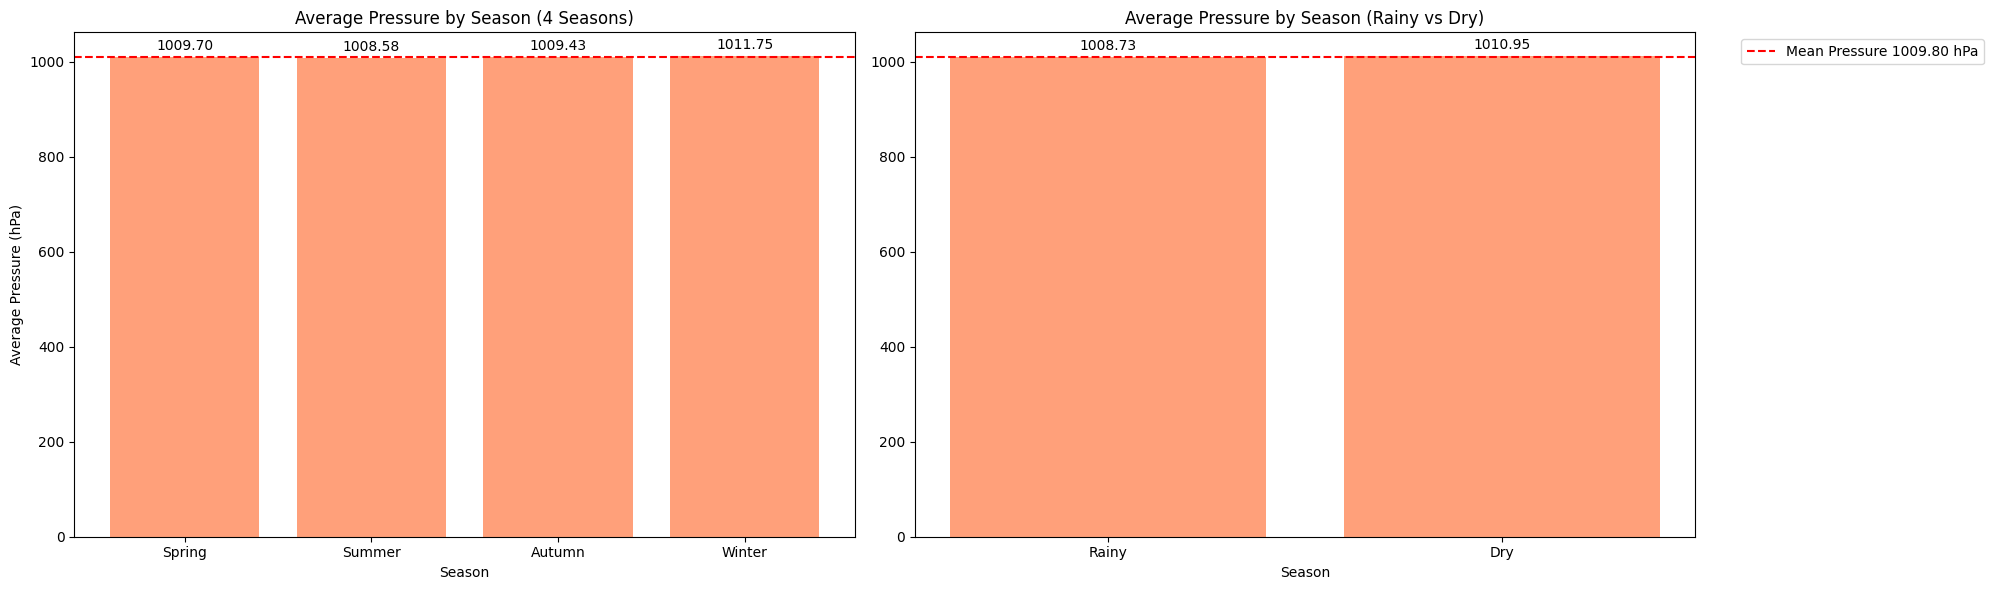

In [16]:
seasons4 = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

seasons_rain_dry = {
    'Rainy': [5, 6, 7, 8, 9, 10],
    'Dry': [11, 12, 1, 2, 3, 4]
}


avg_pres_seasonal4 = {}
avg_pres_seasonal_rain_dry = {}
# Tính áp suất trung bình theo mùa - 4 mùa trong năm
for season, months in seasons4.items():
    avg_pres_seasonal4[season] = df_final.loc[df_final.index.month.isin(months), 'pres'].mean()

# Tính áp suất trung bình theo mùa - mùa mưa và mùa khô
for season, months in seasons_rain_dry.items():
    avg_pres_seasonal_rain_dry[season] = df_final.loc[df_final.index.month.isin(months), 'pres'].mean()

# tính áp suất trung bình tổng
mean_pressure = df_final['pres'].mean()

fig,axo = plt.subplots(1,2, figsize =(20,6))
# Biểu đồ thanh áp suất trung bình theo 4 mùa trong năm
bars1 = axo[0].bar(avg_pres_seasonal4.keys(), avg_pres_seasonal4.values(), color='lightsalmon')

# đuong trung bình áp suất

axo[0].axhline(y=mean_pressure, color='red', linestyle='--', label= f'Mean Pressure {mean_pressure:.2f} hPa')

# Thêm tiêu đề và nhãn trục
axo[0].set_title('Average Pressure by Season (4 Seasons)')
axo[0].set_xlabel('Season')
axo[0].set_ylabel('Average Pressure (hPa)')

# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars1:
    height = bar.get_height()
    axo[0].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Biểu đồ thanh áp suất trung bình theo mùa mưa và mùa khô
bars2 = axo[1].bar(avg_pres_seasonal_rain_dry.keys(), avg_pres_seasonal_rain_dry.values(), color='lightsalmon')

# đường trung bình áp suất
axo[1].axhline(y=mean_pressure, color='red', linestyle='--', label= f'Mean Pressure {mean_pressure:.2f} hPa')

# Thêm tiêu đề và nhãn trục
axo[1].set_title('Average Pressure by Season (Rainy vs Dry)')
axo[1].set_xlabel('Season')

# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars2:
    height = bar.get_height()
    axo[1].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
axo[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiện thị biểu đồ
plt.tight_layout()
plt.show()

Dữ liệu quan trắc cho thấy áp suất khí quyển tại Cần Thơ có sự biến thiên từ **1001 hPa đến 1019 hPa**. Mặc dù biên độ dao động này không quá lớn (đặc trưng của vùng nhiệt đới), nhưng nó đóng vai trò như một "công tắc" điều khiển cơ chế phát tán hoặc tích tụ bụi mịn.

### 3. Hiện tượng "Nén khí quyển" tại mức áp suất cao (High Pressure)
Các đợt ô nhiễm nghiêm trọng thường trùng khớp với thời điểm áp suất khí quyển đạt các giá trị cực đại (tiệm cận ngưỡng **1019 hPa**).

* **Cơ chế tác động:** Hệ thống áp cao thường đi kèm với trạng thái khí quyển ổn định, gió lặng và dòng không khí giáng. Dòng khí đi xuống này nén chặt lớp không khí sát mặt đất, tạo thành một "cái vung" vô hình.
* **Hệ quả:** Bụi mịn ($PM_{2.5}$) và khí thải giao thông không thể bốc lên cao để khuếch tán mà bị "nhốt" lại trong tầng không khí mỏng sát mặt đất. Điều này giải thích vì sao trong những ngày trời quang, nắng đẹp (đặc trưng của áp cao) nhưng chỉ số AQI lại thường ở mức xấu.

### 4. Sự "Giải phóng" tại mức áp suất thấp (Low Pressure)
Ngược lại, các giá trị áp suất thấp (tiệm cận ngưỡng **1001 hPa**) thường là chỉ báo của điều kiện thời tiết bất ổn định, gắn liền với mưa hoặc bão.

* **Cơ chế tác động:** Áp thấp tạo ra dòng không khí thăng (rising air) và tăng cường sự đối lưu, giúp đưa chất ô nhiễm lên các tầng khí quyển cao hơn và phát tán đi xa.
* **Hệ quả:** Đi kèm với áp thấp thường là mưa và gió (như đã phân tích ở báo cáo lượng mưa), kích hoạt cơ chế rửa trôi tự nhiên, đưa nồng độ bụi về mức nền an toàn.

### 5. Mối liên hệ với Nghịch nhiệt
Dữ liệu áp suất cao (1019 hPa) cũng là dấu hiệu cảnh báo rủi ro của hiện tượng **nghịch nhiệt bức xạ** vào ban đêm và sáng sớm.
> Khi áp suất cao kết hợp với đêm trời quang và gió nhẹ, mặt đất mất nhiệt nhanh, làm lớp không khí sát đất lạnh hơn lớp khí bên trên. Đây là điều kiện lý tưởng để giữ lại toàn bộ lượng khói bụi sinh ra từ hoạt động giao thông và sinh hoạt buổi tối, dẫn đến các đỉnh ô nhiễm cực đoan vào lúc 7:00 sáng như đã phân tích trước đó.

### Kết luận
Áp suất khí quyển tại Cần Thơ tỷ lệ thuận với mức độ tích tụ ô nhiễm.
* **Áp suất tăng ($\rightarrow$ 1019 hPa):** Nguy cơ ô nhiễm cao (Khí quyển tù đọng).
* **Áp suất giảm ($\rightarrow$ 1001 hPa):** Chất lượng không khí cải thiện (Khí quyển thông thoáng).

## Phân tích độ ẩm tương đối

### 1. Phân bố độ ẩm 

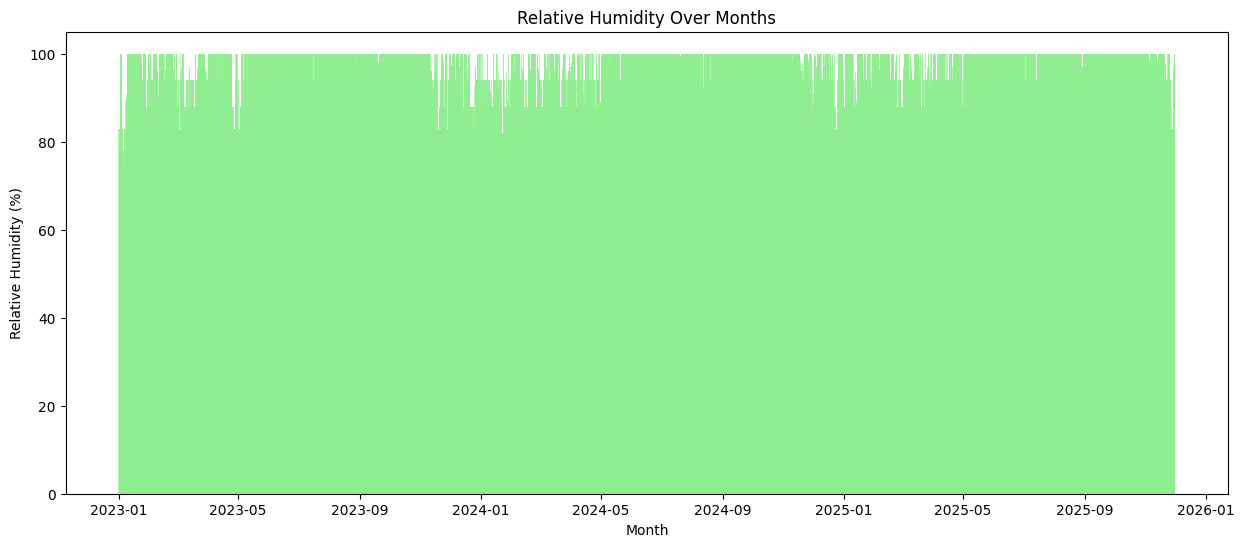

In [17]:
plt.figure(figsize=(15, 6))
plt.bar(df_final.index, df_final['rh'], color='lightgreen', alpha=0.7)
plt.title('Relative Humidity Over Months')
plt.xlabel('Month')
plt.ylabel('Relative Humidity (%)')
plt.show()

### 2. Trung bình của từng mùa

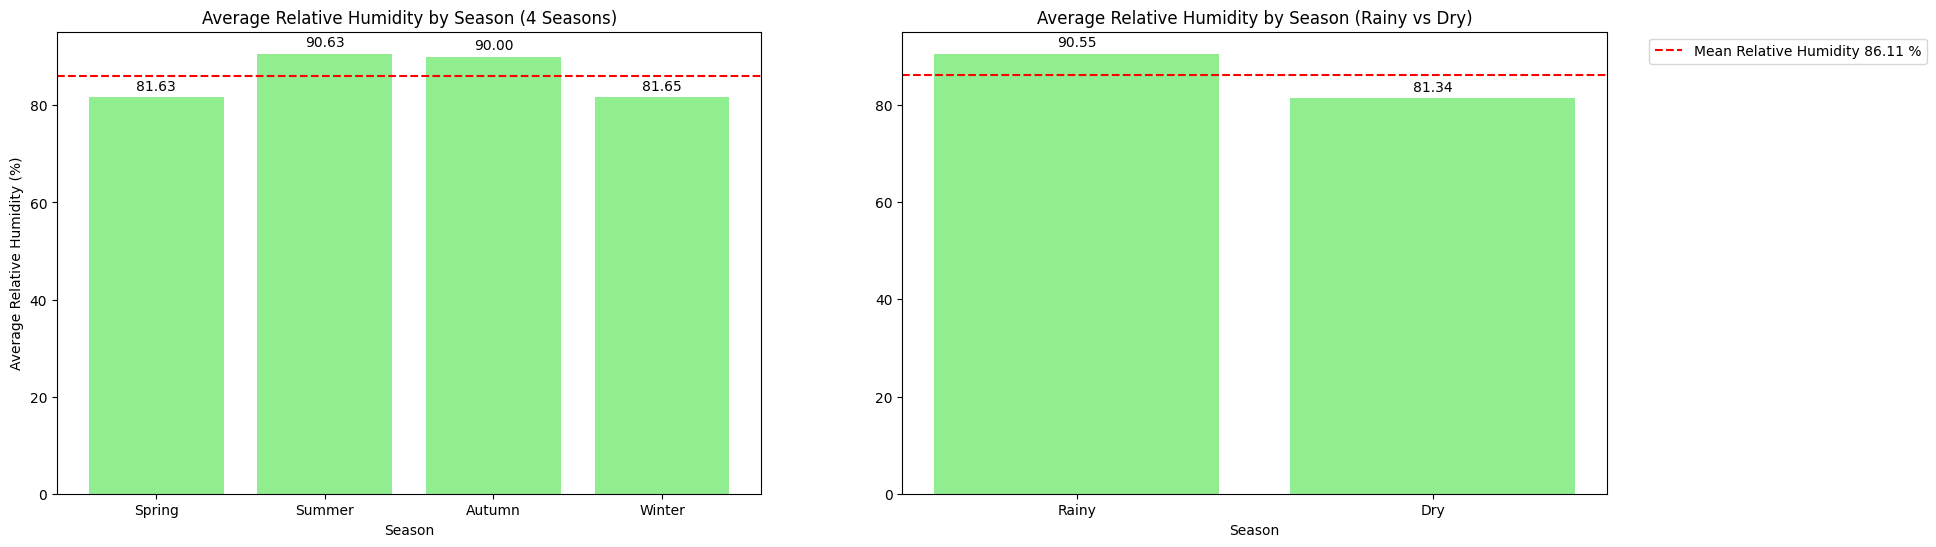

In [18]:
seasons4 = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

seasons_rain_dry = {
    'Rainy': [5, 6, 7, 8, 9, 10],
    'Dry': [11, 12, 1, 2, 3, 4]
}

# Tính độ ẩm trung bình theo mùa - 4 mùa trong năm
avg_rh_seasonal4 = {}
for season, months in seasons4.items():
    avg_rh_seasonal4[season] = df_final.loc[df_final.index.month.isin(months), 'rh'].mean()
# Tính độ ẩm trung bình theo mùa - mùa mưa và mùa khô
avg_rh_seasonal_rain_dry = {}
for season, months in seasons_rain_dry.items():
    avg_rh_seasonal_rain_dry[season] = df_final.loc[df_final.index.month.isin(months), 'rh'].mean()

fig,axo = plt.subplots(1,2, figsize =(20,6))
# Biểu đồ thanh độ ẩm trung bình theo 4 mùa trong năm
bars1 = axo[0].bar(avg_rh_seasonal4.keys(), avg_rh_seasonal4.values(), color='lightgreen')

# đuong trung bình độ ẩm
mean_rh = df_final['rh'].mean()
axo[0].axhline(y=mean_rh, color='red', linestyle='--', label= f'Mean Relative Humidity {mean_rh:.2f} %')
# Thêm tiêu đề và nhãn trục
axo[0].set_title('Average Relative Humidity by Season (4 Seasons)')
axo[0].set_xlabel('Season')
axo[0].set_ylabel('Average Relative Humidity (%)')
# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars1:
    height = bar.get_height()
    axo[0].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Biểu đồ thanh độ ẩm trung bình theo mùa mưa và mùa khô
bars2 = axo[1].bar(avg_rh_seasonal_rain_dry.keys(), avg_rh_seasonal_rain_dry.values(), color='lightgreen')

# đường trung bình độ ẩm
axo[1].axhline(y=mean_rh, color='red', linestyle='--', label= f'Mean Relative Humidity {mean_rh:.2f} %')
# Thêm tiêu đề và nhãn trục
axo[1].set_title('Average Relative Humidity by Season (Rainy vs Dry)')
axo[1].set_xlabel('Season')
# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars2:
    height = bar.get_height()
    axo[1].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
axo[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Dữ liệu quan trắc khí tượng tại Cần Thơ ghi nhận những chỉ số cực đoan về độ ẩm: Độ ẩm tương đối ($RH$) thường xuyên chạm ngưỡng bão hòa $100\%$ và nhiệt độ điểm sương đạt mức kỷ lục $30.3 ^\circ C$.

Điều này chỉ ra rằng lượng hơi nước tuyệt đối trong không khí tại Cần Thơ là rất lớn. Khác với suy nghĩ thông thường rằng "ẩm ướt sẽ làm sạch không khí", trạng thái **ẩm nhưng không mưa** này thực tế lại là một tác nhân làm trầm trọng thêm tình trạng ô nhiễm thông qua hai cơ chế vật lý:

### 4. Cơ chế "Tăng trưởng hút ẩm"
Với độ ẩm bão hòa ($100\%$), các hạt bụi mịn ($PM_{2.5}$) và các hợp chất hòa tan (như muối $Sulfate$, $Nitrate$) đóng vai trò là hạt nhân ngưng tụ.

* **Hiện tượng:** Các hạt bụi này hấp thụ hơi nước mạnh mẽ, trương nở và gia tăng kích thước nhanh chóng.
* **Hệ quả:** Từ các hạt siêu mịn vô hình, chúng trở thành các hạt sương mù dày đặc (haze/mist). Điều này không chỉ làm giảm tầm nhìn nghiêm trọng mà còn biến bầu không khí thành một "hỗn hợp súp" các chất ô nhiễm lơ lửng, khó bị gió cuốn đi do trọng lượng hạt tăng lên.

### 5. Chỉ số Điểm sương cao và Sự ngột ngạt khí quyển
Giá trị nhiệt độ điểm sương cực đại $30.3 ^\circ C$ là một con số rất cao (thông thường trên $24^\circ C$ con người đã cảm thấy rất oi bức/khó chịu).

* **Ý nghĩa vật lý:** Điểm sương càng cao chứng tỏ mật độ hơi nước trong một đơn vị thể tích không khí càng lớn. Không khí trở nên "đặc" và nặng nề.
* **Tác động đến ô nhiễm:** Mật độ hơi nước cao làm giảm khả năng vận động hỗn loạn của không khí (giảm sự xáo trộn nhiệt). Điều này tạo ra một môi trường khí quyển tù đọng, khiến các khí thải độc hại như $CO$ hay $NO_2$ bị giữ lại sát mặt đất thay vì khuếch tán lên cao.

### 6. Sự khác biệt với Mưa
Cần phân biệt rõ giữa **Độ ẩm cao** và **Mưa**:
* **Mưa:** Là quá trình hạt nước rơi xuống, cuốn theo bụi bẩn (Cơ chế làm sạch - Wash out).
* **Độ ẩm cao:** Là hơi nước lơ lửng. Khi không tạo thành mưa, nó hoạt động như một "lớp keo" giữ bụi bẩn lơ lửng lâu hơn trong không khí.

### Kết luận
Trạng thái "Độ ẩm bão hòa + Điểm sương cao" tại Cần Thơ chính là điều kiện lý tưởng để kích hoạt các phản ứng hóa học thứ cấp tạo ra bụi mịn mới, đồng thời ngăn cản sự phát tán cơ học của gió. Đây là lý do tại sao trong những ngày nồm ẩm hoặc sương mù dày, chỉ số AQI thường duy trì ở mức kém dù không có thêm nguồn phát thải mới.

## Phân tích nền nhiệt

### 1.Phân bộ nhiệt độ

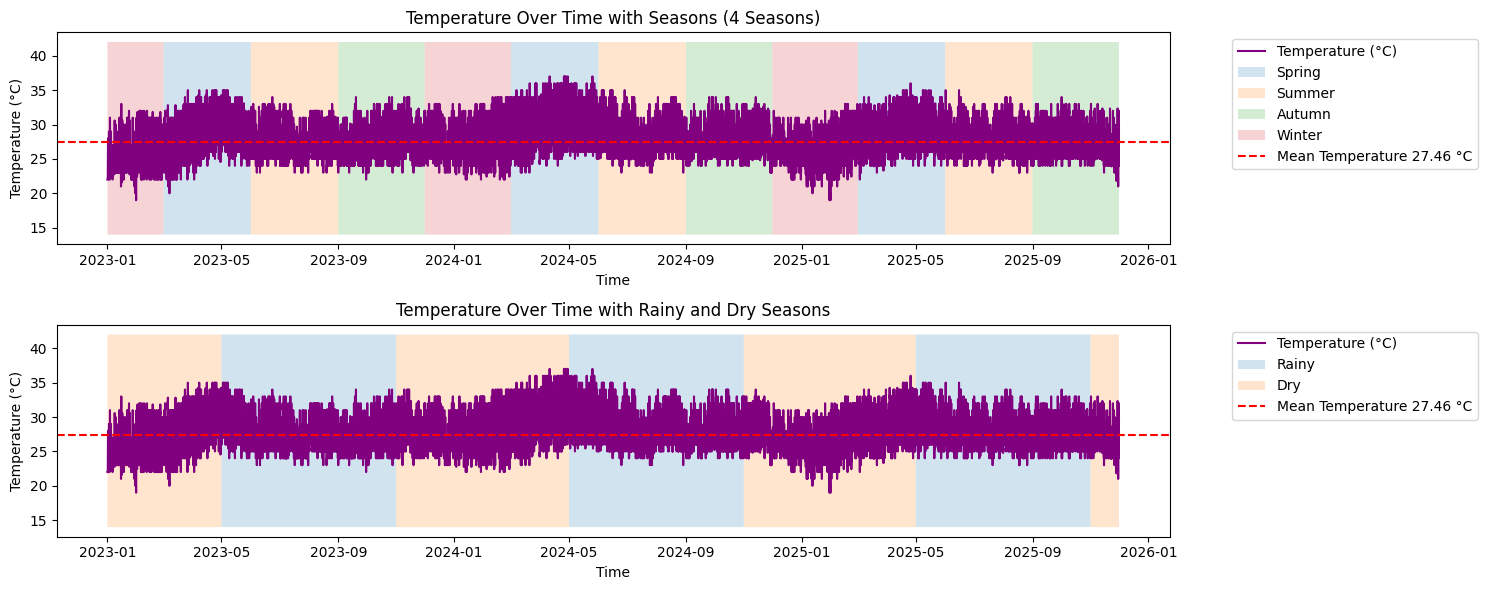

In [19]:
seasons4 = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

seasons_rain_dry = {
    'Rainy': [5, 6, 7, 8, 9, 10],
    'Dry': [11, 12, 1, 2, 3, 4]
}

fig,axo = plt.subplots(2,1, figsize =(15,6))

axo[0].plot(df_final.index, df_final['temp'], color='purple', label='Temperature (°C)')
# Điền màu cho các mùa
for season, months in seasons4.items():
    axo[0].fill_between(df_final.index, df_final['temp'].min() -5, df_final['temp'].max() + 5,
                     where=df_final.index.month.isin(months), 
                     alpha=0.2, label=season)
# đường trung bình nhiệt độ
mean_temp = df_final['temp'].mean()
axo[0].axhline(y=mean_temp, color='red', linestyle='--', label= f'Mean Temperature {mean_temp:.2f} °C')
# Thêm tiêu đề và nhãn trục
axo[0].set_title('Temperature Over Time with Seasons (4 Seasons)')
axo[0].set_xlabel('Time')
axo[0].set_ylabel('Temperature (°C)')
axo[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Mùa mưa và mùa khô
axo[1].plot(df_final.index, df_final['temp'], color='purple', label='Temperature (°C)')
# Điền màu cho mùa mưa và mùa khô
for season, months in seasons_rain_dry.items():
    axo[1].fill_between(df_final.index, df_final['temp'].min() -5, df_final['temp'].max() + 5,
                     where=df_final.index.month.isin(months), 
                     alpha=0.2, label=season)
# đường trung bình nhiệt độ
mean_temp_rain_dry = df_final['temp'].mean()
axo[1].axhline(y=mean_temp_rain_dry, color='red', linestyle='--', label= f'Mean Temperature {mean_temp_rain_dry:.2f} °C')
# Thêm tiêu đề và nhãn trục
axo[1].set_title('Temperature Over Time with Rainy and Dry Seasons')
axo[1].set_xlabel('Time')
axo[1].set_ylabel('Temperature (°C)')
axo[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Hiện thị biểu đồ
plt.tight_layout()
plt.show()

### 2.Nhiệt độ trung bình của từng mùa

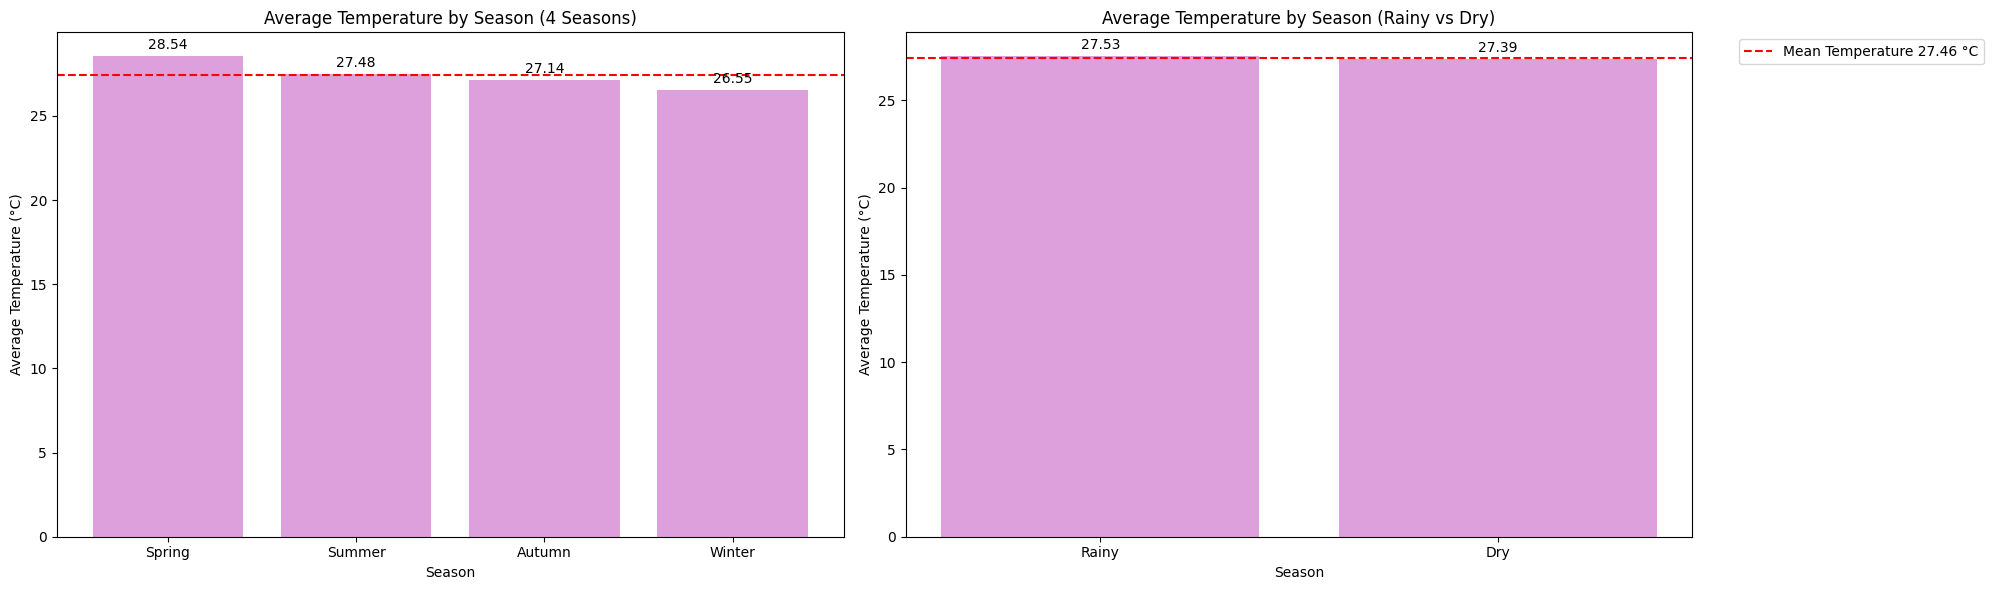

In [20]:
seasons4 = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

seasons_rain_dry = {
    'Rainy': [5, 6, 7, 8, 9, 10],
    'Dry': [11, 12, 1, 2, 3, 4]
}

# Tính nhiệt độ trung bình theo mùa
avg_temp_seasonal4 = {}
avg_temp_seasonal_rain_dry = {}
# Tính nhiệt độ trung bình theo mùa - 4 mùa trong năm
for season, months in seasons4.items():
    avg_temp_seasonal4[season] = df_final.loc[df_final.index.month.isin(months), 'temp'].mean()

# Tính nhiệt độ trung bình theo mùa - mùa mưa và mùa khô
for season, months in seasons_rain_dry.items():
    avg_temp_seasonal_rain_dry[season] = df_final.loc[df_final.index.month.isin(months), 'temp'].mean()

fig,axo = plt.subplots(1,2, figsize =(20,6))
# Biểu đồ thanh nhiệt độ trung bình theo 4 mùa trong năm
bars1 = axo[0].bar(avg_temp_seasonal4.keys(), avg_temp_seasonal4.values(), color='plum')
# đuong trung bình nhiệt độ
mean_temp = df_final['temp'].mean()
axo[0].axhline(y=mean_temp, color='red', linestyle='--', label= f'Mean Temperature {mean_temp:.2f} °C')
# Thêm tiêu đề và nhãn trục
axo[0].set_title('Average Temperature by Season (4 Seasons)')
axo[0].set_xlabel('Season')
axo[0].set_ylabel('Average Temperature (°C)')
# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars1:
    height = bar.get_height()
    axo[0].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Biểu đồ thanh nhiệt độ trung bình theo mùa mưa và mùa khô
bars2 = axo[1].bar(avg_temp_seasonal_rain_dry.keys(), avg_temp_seasonal_rain_dry.values(), color='plum')
# đường trung bình nhiệt độ
axo[1].axhline(y=mean_temp, color='red', linestyle='--', label= f'Mean Temperature {mean_temp:.2f} °C')
# Thêm tiêu đề và nhãn trục
axo[1].set_title('Average Temperature by Season (Rainy vs Dry)')
axo[1].set_xlabel('Season')
axo[1].set_ylabel('Average Temperature (°C)')
# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars2:
    height = bar.get_height()
    axo[1].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

axo[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiện thị biểu đồ
plt.tight_layout()
plt.show()

Dựa trên kết quả định lượng từ tập dữ liệu và quan sát hình thái của hai biểu đồ nhiệt độ, có thể rút ra những nhận định cốt lõi sau về nền nhiệt tại Cần Thơ:

### 3. Phân tích nền nhiệt chung (Dựa trên Biểu đồ Phân phối)
Biểu đồ phân phối xác suất cho thấy Cần Thơ sở hữu một nền nhiệt độ đặc trưng của vùng khí hậu nhiệt đới ổn định, nhưng có xu hướng thiên về nhiệt độ cao.

* **Sự ổn định cao:** Giá trị trung bình ($Mean$) đạt **$27.46^\circ C$** với độ lệch chuẩn ($Std$) rất thấp, chỉ khoảng **$2.84$**. Điều này cho thấy biên độ dao động nhiệt tại Cần Thơ không lớn, biểu đồ có dạng "nhọn" tập trung dày đặc quanh ngưỡng $26^\circ C - 29^\circ C$.
* **Hiếm gặp lạnh:** Giá trị nhỏ nhất ($Min$) ghi nhận là **$19.0^\circ C$**. Tần suất xuất hiện của các giá trị dưới $20^\circ C$ trên biểu đồ là cực kỳ thấp (phần đuôi bên trái rất mỏng), chỉ xảy ra cục bộ vào các thời điểm ban đêm hoặc rạng sáng trong các tháng mùa Đông.

### 4. Phân tích các giá trị cực đại (Dựa trên các đỉnh biểu đồ)
Đáng chú ý nhất trên các biểu đồ là sự xuất hiện của các giá trị cực đoan về phía bên phải (Right tail):

* **Đỉnh nhiệt độ ($Max$):** Hệ thống ghi nhận mức nhiệt cao nhất lên tới **$37.0^\circ C$**.
* **Ý nghĩa số liệu:** Mức $37.0^\circ C$ là ngưỡng "nắng nóng gay gắt". Trong bối cảnh độ ẩm tại Cần Thơ thường xuyên bão hòa (như đã phân tích ở các báo cáo trước), mức nhiệt này tạo ra chỉ số cảm nhận thực tế có thể vượt quá $40^\circ C - 42^\circ C$, gây ra cảm giác oi bức ngột ngạt nghiêm trọng.
* **Tác động môi trường:** Tại mức nhiệt $37.0^\circ C$ này, các phản ứng quang hóa trong khí quyển diễn ra mạnh nhất, thúc đẩy sự hình thành của Ozone ($O_3$) và các bụi phân tử thứ cấp.

### 5. Phân tích biến thiên theo thời gian (Dựa trên Biểu đồ Chuỗi thời gian/Mùa)
Quan sát biểu đồ diễn biến nhiệt độ theo thời gian cho thấy tính chu kỳ rõ rệt:

* **Giai đoạn "Lò nung":** Đường biểu diễn nhiệt độ thường xuyên chạm các đỉnh cao nhất ($>35^\circ C$) vào các tháng mùa khô (tháng 3, 4, 5). Đây là giai đoạn bức xạ mặt trời mạnh nhất, trùng khớp với các đợt ô nhiễm không khí cao điểm.
* **Giai đoạn "Hạ nhiệt":** Nhiệt độ có xu hướng giảm nhẹ và ổn định hơn vào mùa mưa và mùa Thu, khi lượng mây che phủ tăng lên và mưa đóng vai trò điều hòa khí hậu.

### Kết luận
Số liệu nhiệt độ tại Cần Thơ cho thấy một môi trường khí hậu **"Nóng ẩm quanh năm - Cao điểm gay gắt vào Mùa Xuân"**.
Sự chênh lệch giữa nhiệt độ trung bình ($27.46^\circ C$) và nhiệt độ cực đại ($37.0^\circ C$) lên tới gần $10^\circ C$. Chính khoảng chênh lệch này, diễn ra trong các đợt nắng nóng ngắn hạn, là tác nhân chính gây xáo trộn trạng thái khí quyển, ảnh hưởng trực tiếp đến khả năng khuếch tán chất ô nhiễm của thành phố.

## Phân tích sức gió và hướng gió

### 1. Sức gió  và hướng gió trong suốt các năm

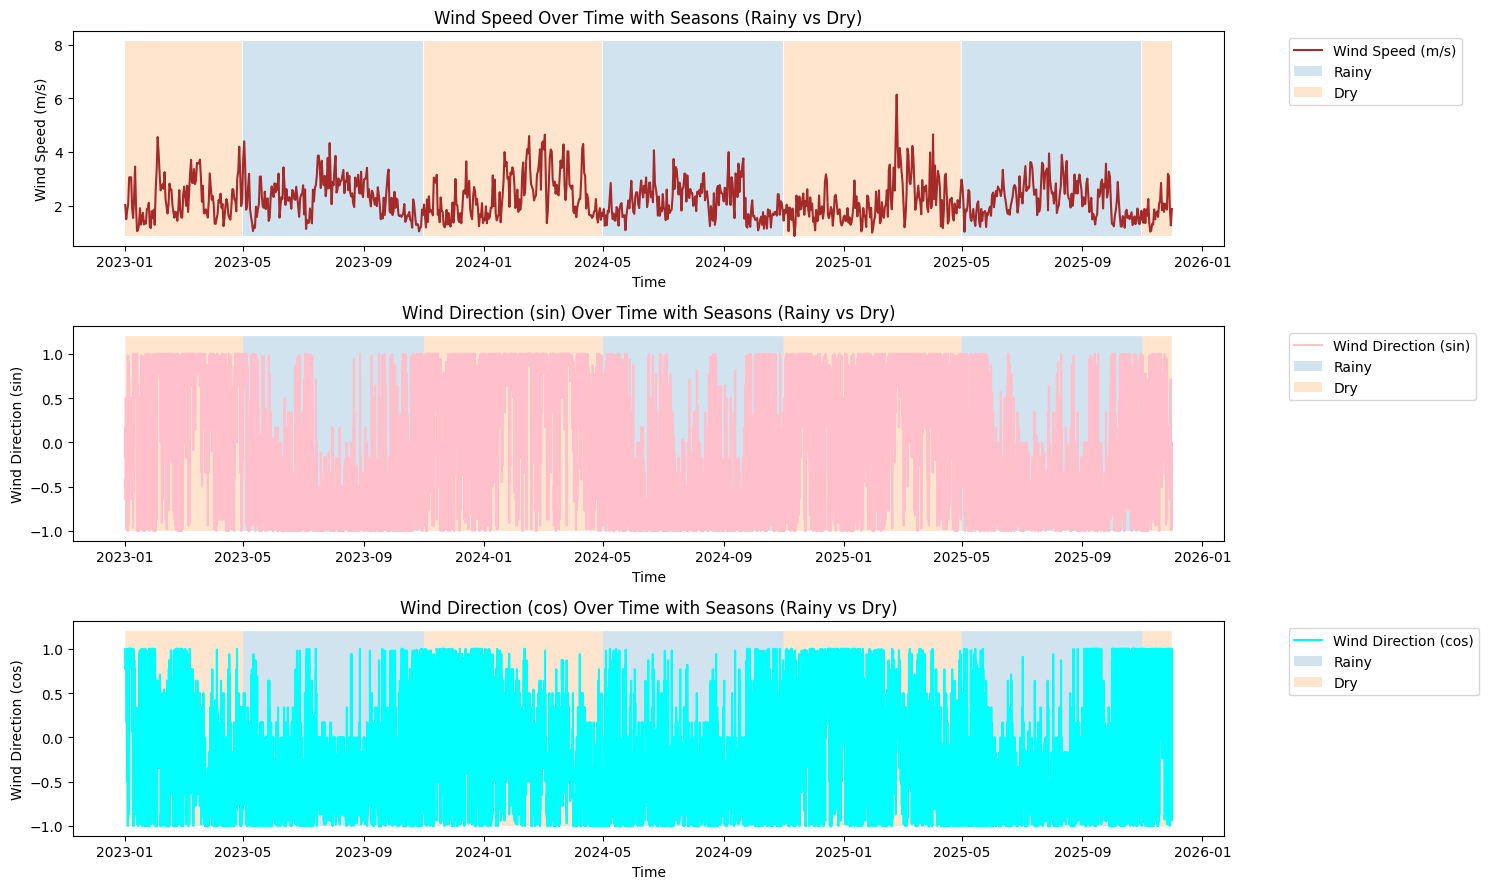

In [21]:
seasons4 = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

seasons_rain_dry = {
    'Rainy': [5, 6, 7, 8, 9, 10],
    'Dry': [11, 12, 1, 2, 3, 4]
}

df_wind = df_final[['wind_spd',"wind_dir", 'wind_sin', 'wind_cos']].copy().resample('d').mean()

fig,axo = plt.subplots(3,1, figsize =(15,9))

# Mùa mưa và mùa khô
axo[0].plot(df_wind.index, df_wind['wind_spd'], color='brown', label='Wind Speed (m/s)')
# Điền màu cho mùa mưa và mùa khô
for season, months in seasons_rain_dry.items():
    axo[0].fill_between(df_wind.index, df_wind['wind_spd'].min(), df_wind['wind_spd'].max() + 2,
                     where=df_wind.index.month.isin(months), 
                     alpha=0.2, label=season)
# chú thích
axo[0].set_title('Wind Speed Over Time with Seasons (Rainy vs Dry)')
axo[0].set_xlabel('Time')
axo[0].set_ylabel('Wind Speed (m/s)')
axo[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Huớng gió theo 4 mùa trong năm theo sin 
axo[1].plot(df_final.index, df_final['wind_sin'], color='pink', label='Wind Direction (sin)')
# Điền màu cho các mùa
for season, months in seasons_rain_dry.items():
    axo[1].fill_between(df_final.index, df_final['wind_sin'].min(), df_final['wind_sin'].max() + 0.2,
                     where=df_final.index.month.isin(months), 
                     alpha=0.2, label=season)
# chú thích
axo[1].set_title('Wind Direction (sin) Over Time with Seasons (Rainy vs Dry)')
axo[1].set_xlabel('Time')
axo[1].set_ylabel('Wind Direction (sin)')
axo[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Huớng gió theo mùa mưa và mùa khô theo cos
axo[2].plot(df_final.index, df_final['wind_cos'], color="cyan", label='Wind Direction (cos)')
# Điền màu cho mùa mưa và mùa khô
for season, months in seasons_rain_dry.items():
    axo[2].fill_between(df_final.index, df_final['wind_cos'].min(), df_final['wind_cos'].max() + 0.2,
                     where=df_final.index.month.isin(months), 
                     alpha=0.2, label=season)
# chú thích
axo[2].set_title('Wind Direction (cos) Over Time with Seasons (Rainy vs Dry)')
axo[2].set_xlabel('Time')
axo[2].set_ylabel('Wind Direction (cos)')
axo[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')


# Hiện thị biểu đồ
plt.tight_layout()
plt.show()

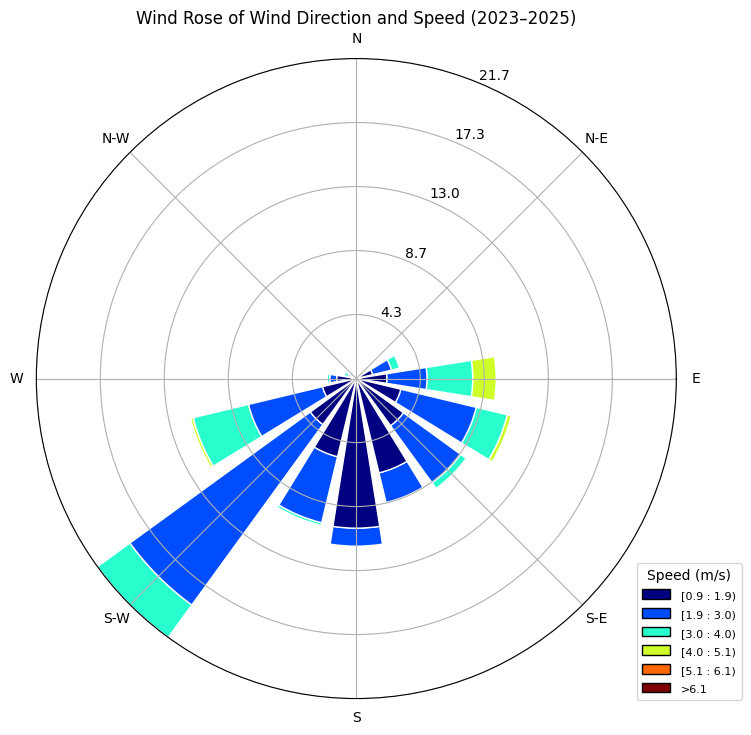

In [22]:
fig = plt.figure(figsize=(8, 8))
rect = [0.1, 0.1, 0.8, 0.8] # Vị trí khung
ax = WindroseAxes(fig, rect)
fig.add_axes(ax)

# Vẽ biểu đồ
# normed=True: Hiển thị phần trăm (%) tần suất
# opening=0.8: Độ rộng của các cánh quạt (0.0 - 1.0)
# cmap=cm.hot: Bảng màu (có thể đổi thành cm.jet, cm.viridis...)
ax.bar(df_wind['wind_dir'], df_wind['wind_spd'], 
       normed=True, opening=0.8, edgecolor='white', cmap=cm.jet)

# Chú thích
ax.set_legend(title="Speed (m/s)", loc='lower right', bbox_to_anchor=(1.1, 0))
plt.title("Wind Rose of Wind Direction and Speed (2023–2025)")
plt.show()




### 2. Tốc độ gió trung bình của từng mùa

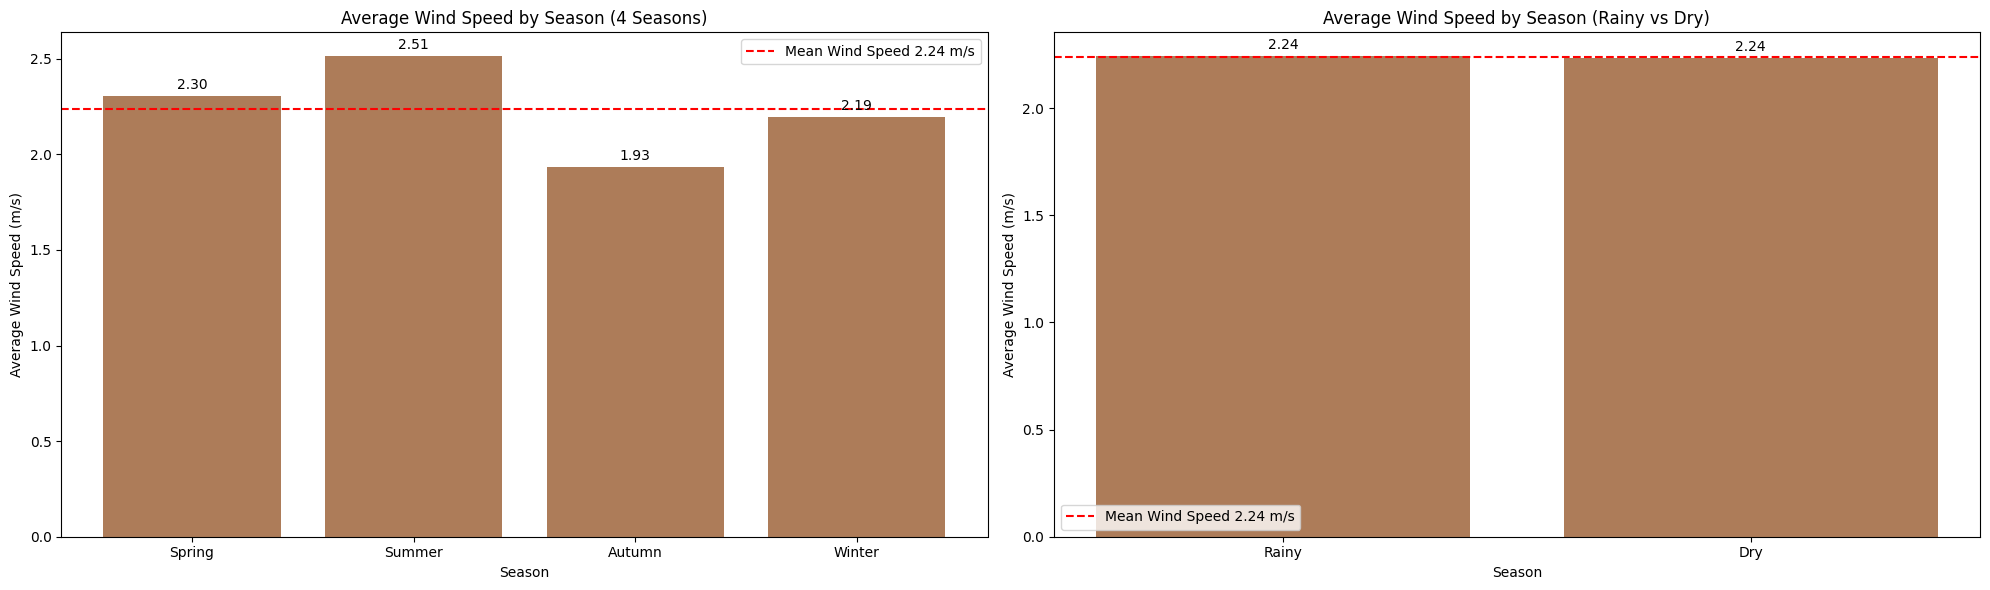

In [23]:
seasons4 = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

seasons_rain_dry = {
    'Rainy': [5, 6, 7, 8, 9, 10],
    'Dry': [11, 12, 1, 2, 3, 4]
}

avg_wind_spd_seasonal4 = {}
avg_wind_spd_seasonal_rain_dry = {}

# Tính vận tốc gió trung bình theo mùa - 4 mùa trong năm
for season, months in seasons4.items():
    avg_wind_spd_seasonal4[season] = df_final.loc[df_final.index.month.isin(months), 'wind_spd'].mean()

# Tính vận tốc gió trung bình theo mùa - mùa mưa và mùa khô
for season, months in seasons_rain_dry.items():
    avg_wind_spd_seasonal_rain_dry[season] = df_final.loc[df_final.index.month.isin(months), 'wind_spd'].mean()

fig,axo = plt.subplots(1,2, figsize =(20,6))
# Biểu đồ thanh vận tốc gió trung bình theo 4 mùa trong năm
bars1 = axo[0].bar(avg_wind_spd_seasonal4.keys(), avg_wind_spd_seasonal4.values(), color='saddlebrown', alpha=0.7)
# đuong trung bình vận tốc gió
mean_wind_spd = df_final['wind_spd'].mean()
axo[0].axhline(y=mean_wind_spd, color='red', linestyle='--', label= f'Mean Wind Speed {mean_wind_spd:.2f} m/s')
# Thêm tiêu đề và nhãn trục
axo[0].set_title('Average Wind Speed by Season (4 Seasons)')
axo[0].set_xlabel('Season')
axo[0].set_ylabel('Average Wind Speed (m/s)')
axo[0].legend()

# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars1:
    height = bar.get_height()
    axo[0].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Biểu đồ thanh vận tốc gió trung bình theo mùa mưa và mùa khô
bars2 = axo[1].bar(avg_wind_spd_seasonal_rain_dry.keys(), avg_wind_spd_seasonal_rain_dry.values(), color='saddlebrown', alpha=0.7)
# đường trung bình vận tốc gió
axo[1].axhline(y=mean_wind_spd, color='red', linestyle='--', label= f'Mean Wind Speed {mean_wind_spd:.2f} m/s')
# Thêm tiêu đề và nhãn trục
axo[1].set_title('Average Wind Speed by Season (Rainy vs Dry)')
axo[1].set_xlabel('Season')
axo[1].set_ylabel('Average Wind Speed (m/s)')
axo[1].legend()

# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars2:
    height = bar.get_height()
    axo[1].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Hiện thị biểu đồ
plt.tight_layout()
plt.show()

### 3.  Phân bố đặc trưng hướng gió trong không gian

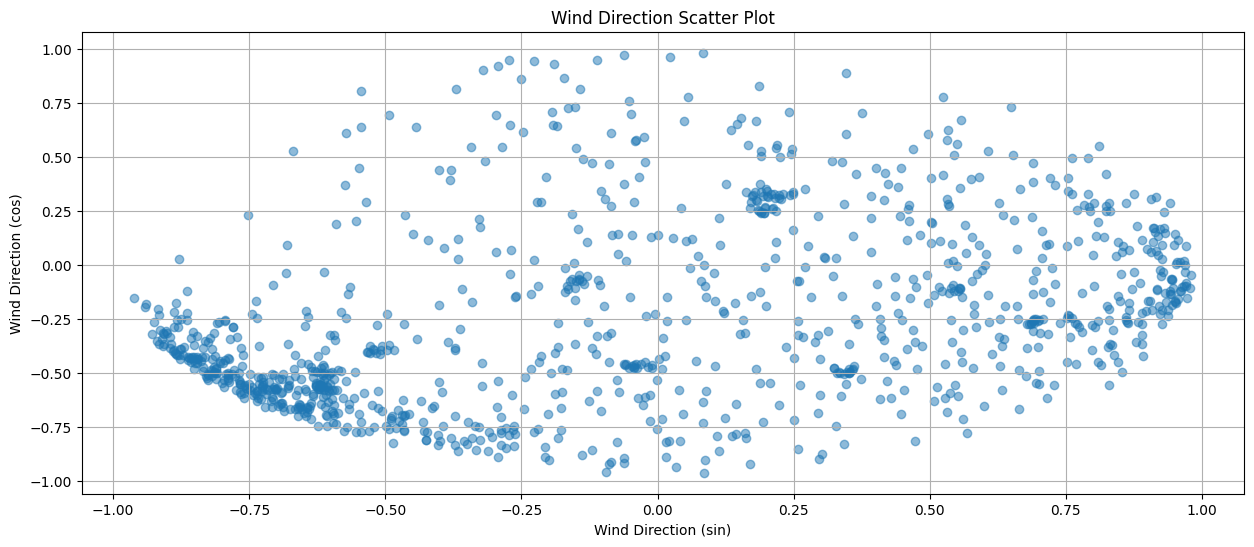

In [24]:
plt.figure(figsize=(15, 6))

plt.scatter(df_wind["wind_sin"], df_wind["wind_cos"], alpha=0.5)
plt.title("Wind Direction Scatter Plot")
plt.xlabel("Wind Direction (sin)")
plt.ylabel("Wind Direction (cos)")
plt.grid(True)
plt.show()

Dựa trên quan sát trực quan từ hệ thống biểu đồ diễn biến gió theo thời gian, TP. Cần Thơ thể hiện rõ nét đặc trưng của khu vực chịu ảnh hưởng bởi **Cơ chế Gió mùa**.

Sự luân chuyển nhịp nhàng của hướng gió (thể hiện qua sự đảo chiều của `sin`/`cos`) trùng khớp với chu kỳ Mưa - Nắng là yếu tố then chốt quyết định "số phận" của các chất ô nhiễm trong không khí.

### 4. Phân tích Chi tiết 4 Đặc trưng

#### a) Đặc trưng về Cường độ
*Quan sát từ biểu đồ trên cùng:*
* **Biến động nền:** Đường biểu diễn tốc độ gió dao động chủ yếu ở mức thấp (dưới ngưỡng trung bình). Các đỉnh nhọn (spikes) biểu thị gió mạnh xuất hiện nhưng không dày đặc.
* **Tương quan mùa vụ:**
    * Trong các vùng được tô màu (đại diện cho các mùa), không có sự chênh lệch quá cực đoan về tốc độ gió trung bình giữa Mùa Mưa và Mùa Khô.
    * Tuy nhiên, cần lưu ý các giai đoạn "trũng" (các điểm thấp nhất của biểu đồ). Đây là những ngày **"Lặng gió"**, thường xuất hiện nhiều hơn vào giai đoạn chuyển mùa.
* **Ý nghĩa môi trường:** Tốc độ gió thấp quanh năm tạo ra hạn chế lớn về khả năng **thông khí tự nhiên**. Các chất ô nhiễm do giao thông và sinh hoạt không được "thổi bay" ngay lập tức mà có xu hướng lơ lửng tại chỗ.

#### b) Đặc trưng về Hướng
*Quan sát từ biểu đồ giữa và dưới:*
Đây là phần thú vị nhất của dữ liệu, biểu đồ `sin` và `cos` thể hiện sự **đối xứng hoàn hảo** theo mùa:

* **Giai đoạn Mùa Khô (Tháng 11 - Tháng 4):**
    * Biểu đồ `sin` và `cos` thường nằm ở miền **Dương (+)**.
    * Tương ứng với hướng gió **Đông Bắc**.
    * *Tác động:* Gió thổi từ lục địa xuống, mang theo không khí khô và bụi từ các hoạt động đốt nông nghiệp vùng lân cận.
* **Giai đoạn Mùa Mưa (Tháng 5 - Tháng 10):**
    * Biểu đồ `sin` và `cos` chuyển sang miền **Âm (-)**.
    * Tương ứng với hướng gió **Tây Nam**.
    * *Tác động:* Gió thổi từ biển vào, mang theo hơi ẩm lớn. Đây là luồng gió "sạch", kết hợp với mưa giúp rửa trôi bầu không khí.

#### c) Đặc trưng Giao thoa
*Quan sát các điểm giao nhau giữa các vùng màu:*
* Tại các điểm giao thoa giữa Mùa Mưa và Mùa Khô (tháng 4-5 và tháng 10-11), biểu đồ `sin`/`cos` dao động mạnh quanh trục 0.
* **Hiện tượng:** Đây là giai đoạn gió đổi chiều (xoay gió). Lúc này, khí quyển thường rơi vào trạng thái bất ổn định hoặc tĩnh lặng tạm thời, khiến khả năng dự báo hướng phát tán ô nhiễm trở nên khó khăn hơn.

#### d) Đặc trưng về "Bẫy khí quyển"
*Tổng hợp từ 3 biểu đồ:*
* Có sự trùng hợp đáng báo động: Vào cao điểm Mùa Khô (vùng màu của Dry Season), tốc độ gió thường không cao, trong khi hướng gió lại ổn định từ phía Đông Bắc.
* Sự ổn định này tạo ra một **"Bẫy khí quyển"**: Bụi mịn ($PM_{2.5}$) liên tục được đưa đến từ một hướng, nhưng không đủ gió mạnh để phân tán, cũng không có mưa (đặc trưng mùa khô) để gột rửa.


### 5. Đánh giá Tác động đến Chất lượng Không khí Cần Thơ

Từ việc phân tích 4 sơ đồ trên, ta rút ra 3 kết luận quan trọng về mối quan hệ "Gió - Bụi":

1.  **Mùa Khô là "Mùa Ô nhiễm":**
    * Gió Đông Bắc (thể hiện qua `sin`/`cos` dương) đóng vai trò là "băng chuyền" vận chuyển bụi và khói đốt đồng từ các tỉnh phía Bắc và Đông Bắc vào trung tâm Cần Thơ.
    * Kết hợp với việc thiếu mưa, nồng độ bụi sẽ tích lũy lũy kế theo thời gian.

2.  **Mùa Mưa là "Mùa Làm sạch":**
    * Gió Tây Nam (thể hiện qua `sin`/`cos` âm) mang hơi nước từ biển.
    * Dù tốc độ gió không tăng đột biến, nhưng bản chất khối khí sạch hơn và độ ẩm cao giúp giảm thiểu bụi lơ lửng.

3.  **Rủi ro từ sự "Lặng gió":**
    * Bất kể mùa nào, những ngày đường biểu diễn `wind_spd` chạm đáy là những ngày AQI sẽ chạm đỉnh (Peak Pollution Events).


## Các yếu tố ảnh hướng đến chất lượng không khí

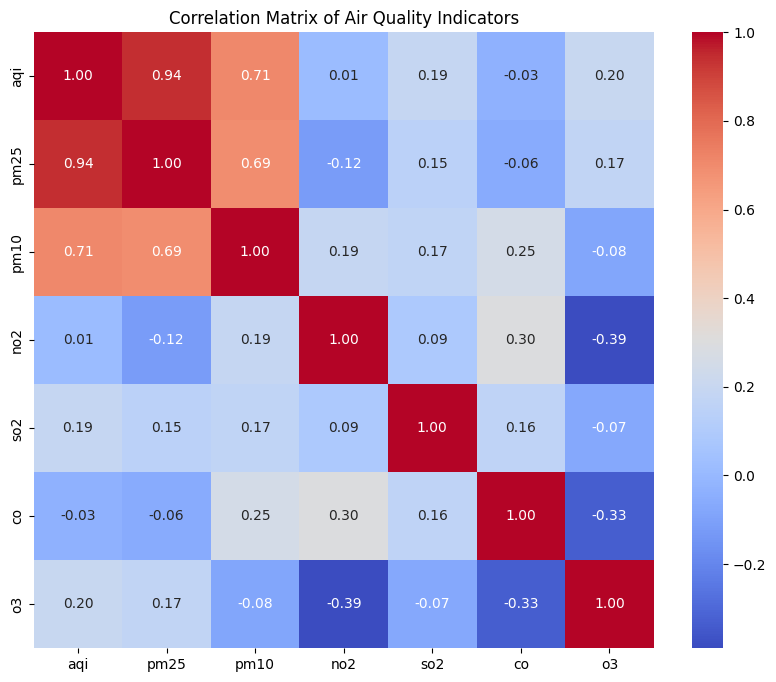

In [25]:
corr_columns = ["aqi","pm25","pm10","no2","so2","co","o3"]

corr_matrix = df_final[corr_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Air Quality Indicators")
plt.show()

Biểu đồ thể hiện hệ số tương quan Pearson giữa chỉ số AQI và các thành phần ô nhiễm (PM2.5, PM10, NO2, SO2, CO, O3). Kết quả cho thấy mức độ phụ thuộc khác nhau của AQI vào từng loại chất thải.

**Phân tích chi tiết**
* **Yếu tố chi phối chính (PM2.5):** Có mối tương quan thuận **rất mạnh** giữa `aqi` và `pm25` với hệ số $r = 0.94$. Điều này khẳng định nồng độ bụi mịn PM2.5 là yếu tố quyết định chính đến giá trị AQI trong tập dữ liệu.
* **Nhóm bụi (PM10):** `pm10` cũng có tương quan thuận mạnh với `aqi` ($r = 0.71$) và tương quan khá chặt chẽ với `pm25` ($r = 0.69$), cho thấy sự đồng biến thiên của hai loại bụi này.
* **Nhóm khí thải (NO2, SO2, CO, O3):** Các chỉ số này có hệ số tương quan với `aqi` rất thấp (từ -0.03 đến 0.20), cho thấy biến động của chúng ít ảnh hưởng trực tiếp đến sự thay đổi của chỉ số AQI tổng thể so với bụi mịn.
* **Tương quan nghịch:** `o3` có mối tương quan nghịch mức độ trung bình với `no2` ($r = -0.39$) và `co` ($r = -0.33$), phản ánh mối quan hệ phức tạp hoặc quy luật biến thiên trái chiều giữa Ozone và các khí thải sơ cấp.

Chất lượng không khí (AQI) trong phạm vi khảo sát phụ thuộc chủ yếu vào mức độ ô nhiễm bụi (đặc biệt là PM2.5). Các khí thải khác đóng vai trò thứ yếu trong việc xác định chỉ số AQI tại khu vực này.

### Ảnh hưởng của lượng mưa đến chất lượng không khí

#### 1. Tính số ngày mưa liên tiếp

In [26]:
count = 0

accumulated_hours_list = []

for precip in df_final['precip']:
    if precip > 0:
        count += 1
    else:
        count = 0
    accumulated_hours_list.append(count)

df_final['accumulated_hours'] = accumulated_hours_list

df_final.head()

,aqi,co,no2,o3,pm10,pm25,so2,temp,rh,pres,wind_spd,wind_dir,clouds,precip,pod,dewpt,wind_sin,wind_cos,accumulated_hours
2023-01-01 00:00:00,152.0,432.8,57.3,22.3,83.3,56.67,37.7,22.0,83.0,1015.0,1.0,320.0,100.0,0.25,0,19.0,-0.64,0.77,1
2023-01-01 01:00:00,150.0,402.1,54.0,20.0,79.0,54.00,32.0,22.0,83.0,1014.0,2.1,330.0,99.0,0.00,0,19.0,-0.50,0.87,0
2023-01-01 02:00:00,134.0,361.2,45.3,24.3,70.3,48.00,31.7,22.0,83.0,1013.0,2.1,330.0,100.0,0.00,0,19.0,-0.50,0.87,0
2023-01-01 03:00:00,118.0,320.4,36.7,28.7,61.7,42.00,31.3,22.0,83.0,1013.0,2.1,335.0,100.0,0.00,0,19.0,-0.42,0.91,0
2023-01-01 04:00:00,102.0,279.5,28.0,33.0,53.0,36.00,31.0,22.0,78.0,1013.0,2.1,330.0,100.0,0.00,0,18.0,-0.50,0.87,0


In [27]:
df_final["accumulated_hours"].describe()

count    25561.000000
mean         2.409178
std          5.657329
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         55.000000
Name: accumulated_hours, dtype: float64

#### 2. Mối quan hệ giữa số giờ mưa liên tiếp và PM 2.5

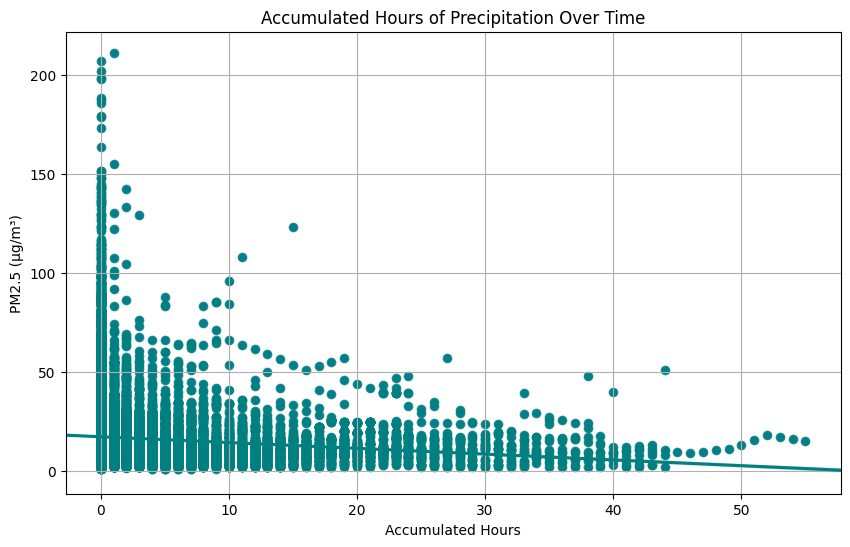

Correlation between Accumulated Hours and PM2.5: -0.11


In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='accumulated_hours', y='pm25')
sns.regplot(data=df_final, x='accumulated_hours', y='pm25', color='teal', truncate=False)
plt.title('Accumulated Hours of Precipitation Over Time')
plt.xlabel('Accumulated Hours')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.show()

correlation = df_final['accumulated_hours'].corr(df_final['pm25'])
print(f'Correlation between Accumulated Hours and PM2.5: {correlation:.2f}')

#### 3. Mối quan hệ giữa lượng mưa PM 2.5

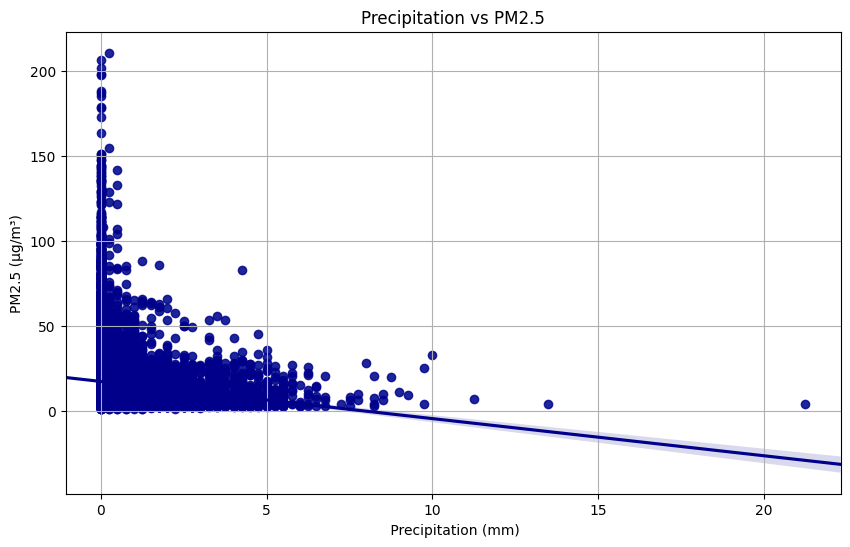

Correlation between Precipitation and PM2.5: -0.11


In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='precip', y='pm25', alpha=0.5,)
sns.regplot(data=df_final, x='precip', y='pm25', color='darkblue', truncate=False)
plt.title('Precipitation vs PM2.5')
plt.xlabel(' Precipitation (mm)')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.show()
    
correlation = df_final['precip'].corr(df_final['pm25'])
print(f'Correlation between Precipitation and PM2.5: {correlation:.2f}')


#### 4. Phân tích chi tiết

##### 4.1.  Mối quan hệ giữa Thời gian mưa tích lũy và PM2.5
*(Dựa trên biểu đồ: Accumulated Hours of Precipitation Over Time)*

* **Hiện trạng tại điểm 0:** Tại mốc 0 giờ (không mưa hoặc mới bắt đầu mưa), nồng độ PM2.5 dao động rất mạnh, đạt các đỉnh cực đại (từ 150 đến trên 200 $\mu g/m^3$). Điều này cho thấy khi thời tiết khô ráo, ô nhiễm có xu hướng tích tụ cao.
* **Xu hướng giảm dần (Trendline):** Đường hồi quy (màu xanh ngọc) có độ dốc âm. Khi số giờ mưa tích lũy tăng lên, nồng độ PM2.5 có xu hướng giảm rõ rệt.
* **Ngưỡng bão hòa làm sạch:** Sau khoảng **20-30 giờ** mưa tích lũy, nồng độ PM2.5 hầu như duy trì ở mức thấp (dưới 50 $\mu g/m^3$) và rất ít biến động.
* **Ý nghĩa:** Mưa kéo dài có tác dụng "làm sạch" bầu không khí hiệu quả thông qua cơ chế lắng đọng ướt (wet deposition).

##### 4.2. Mối quan hệ giữa Cường độ/Lượng mưa và PM2.5
*(Dựa trên biểu đồ: Precipitation vs PM2.5)*

* **Sự tập trung dữ liệu:** Đa số các điểm dữ liệu tập trung ở khu vực lượng mưa thấp (0 - 5mm), nơi nồng độ PM2.5 trải rộng từ thấp đến rất cao.
* **Tương quan nghịch mạnh:** Đường hồi quy (màu xanh đậm) cho thấy độ dốc xuống rất rõ ràng. Ngay cả một lượng mưa nhỏ (dưới 5mm) cũng bắt đầu có tác động giảm thiểu nồng độ bụi.
* **Hiệu quả rửa trôi:** Khi lượng mưa đạt trên **10mm**, hầu như không còn ghi nhận nồng độ PM2.5 ở mức cao nguy hại. Các hạt bụi lơ lửng đã bị rửa trôi gần như hoàn toàn xuống mặt đất.

#### 5. Nhận định về Chất lượng không khí tại Cần Thơ

Kết hợp dữ liệu trên với đặc thù khí hậu nhiệt đới gió mùa tại Cần Thơ (phân chia rõ rệt mùa mưa và mùa khô), ta có thể rút ra các đặc trưng sau:

1.  **Cơ chế tự làm sạch của tự nhiên:**
    Dữ liệu khẳng định mưa là yếu tố then chốt giúp cải thiện chất lượng không khí tại Cần Thơ. Vào **mùa mưa** (thường từ tháng 5 đến tháng 11), chất lượng không khí sẽ tốt hơn đáng kể do hiệu ứng rửa trôi liên tục (như thấy ở các điểm dữ liệu có Accumulated Hours cao).

2.  **Cảnh báo rủi ro trong Mùa khô:**
    Ngược lại, các điểm dữ liệu tập trung dày đặc ở trục tung (trục Y) khi lượng mưa = 0 cảnh báo rủi ro cao vào **mùa khô** hoặc các đợt nắng nóng kéo dài. Khi thiếu vắng sự rửa trôi của nước mưa, bụi mịn từ giao thông, hoạt động công nghiệp và sinh hoạt tại Cần Thơ sẽ tích tụ lơ lửng, dễ dàng vượt ngưỡng an toàn (trên 100 $\mu g/m^3$).

3.  **Hiện tượng tích tụ bụi cục bộ:**
    Các điểm ngoại lai (outliers) có PM2.5 cao ngay cả khi lượng mưa thấp (< 2mm) cho thấy những cơn mưa rào nhẹ hoặc mưa phùn không đủ sức rửa trôi hoàn toàn bụi, đôi khi độ ẩm cao kết hợp mưa nhỏ còn có thể giữ bụi lại tầng thấp lâu hơn trước khi bị cuốn đi.

#### 6. Kết luận 

Có mối **tương quan nghịch** rõ ràng giữa mưa (cả về thời gian và lượng) và nồng độ bụi mịn PM2.5. Mưa càng lớn và kéo dài, không khí càng sạch.

### Ảnh hưởng của áp suất đến chất lượng không khí

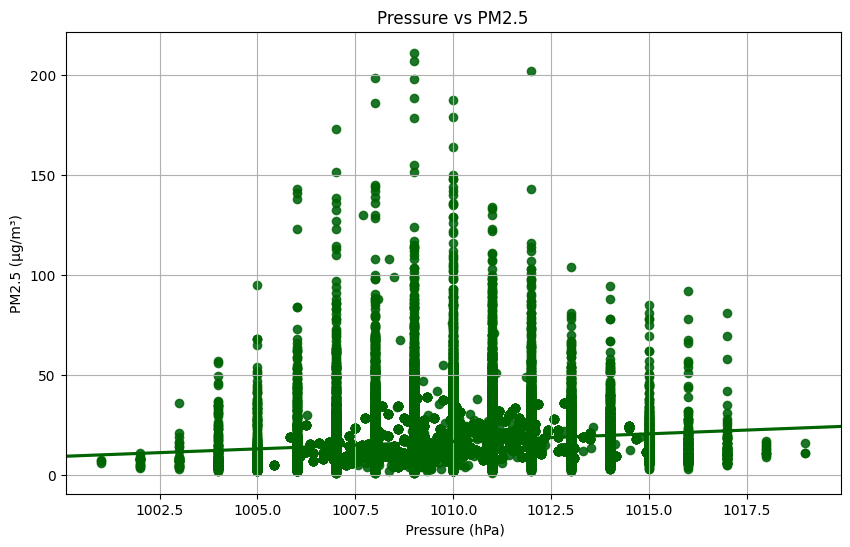

Correlation between Pressure and PM2.5: 0.12


In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='pres', y='pm25', alpha=0.5,)
sns.regplot(data=df_final, x='pres', y='pm25', color='darkgreen', truncate=False)
plt.title('Pressure vs PM2.5')
plt.xlabel(' Pressure (hPa)')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.show()
correlation = df_final['pres'].corr(df_final['pm25'])
print(f'Correlation between Pressure and PM2.5: {correlation:.2f}')

#### 1. Thông số thống kê cơ bản
* **Hệ số tương quan (Pearson Correlation):** $r = 0.11$
* **Loại tương quan:** Tương quan thuận, mức độ yếu (Weak Positive Correlation).
* **Xu hướng chung:** Đường hồi quy (Trendline màu xanh đậm) có xu hướng đi lên nhẹ từ trái sang phải.

#### 2. Phân tích chi tiết biểu đồ (Exploratory Data Analysis)

##### 2.1. Phân bố dữ liệu
* **Dải áp suất:** Dữ liệu áp suất tập trung chủ yếu trong khoảng từ **1000 hPa đến 1018 hPa**. Đây là dải áp suất khí quyển tiêu chuẩn thường thấy ở các vùng nhiệt đới như Cần Thơ.
* **Cấu trúc dữ liệu:** Các điểm dữ liệu xếp thành các hàng dọc (vertical stripes), cho thấy dữ liệu áp suất được ghi nhận ở dạng số nguyên hoặc có độ phân giải làm tròn (ví dụ: 1005, 1006, 1007 hPa...), thay vì là một biến số liên tục mượt mà.
* **Vùng tập trung ô nhiễm cao:** Các giá trị PM2.5 cao nhất (các điểm "đỉnh" vượt ngưỡng 150 - 200 $\mu g/m^3$) tập trung dày đặc nhất ở khoảng áp suất trung bình cao, từ **1008 hPa đến 1012 hPa**.

##### 2.2. Ý nghĩa của hệ số tương quan $r = 0.11$
Mặc dù hệ số $0.11$ là thấp, nhưng dấu dương (+) mang ý nghĩa vật lý quan trọng trong khí tượng học ô nhiễm:
* Khi áp suất khí quyển tăng, nồng độ bụi mịn có xu hướng tăng nhẹ.
* Độ dốc của đường hồi quy thấp cho thấy áp suất **không phải là yếu tố duy nhất hoặc yếu tố mạnh nhất** quyết định ô nhiễm, nhưng nó có đóng góp vào bức tranh tổng thể.

#### 3. Nhận định chuyên môn gắn với bối cảnh Cần Thơ

Dựa trên đặc thù khí hậu nhiệt đới gió mùa tại Cần Thơ, biểu đồ này phản ánh các hiện tượng sau:

##### 3.1. Hiện tượng Nghịch nhiệt và Khí áp cao (High Pressure Stagnation)
Mối tương quan thuận (Pressure tăng -> PM2.5 tăng) phù hợp với lý thuyết khí tượng:
* **Hệ thống áp cao:** Thường đi kèm với điều kiện thời tiết ổn định, gió nhẹ hoặc lặng gió, và hiện tượng giáng khí (không khí chìm xuống).
* **Cơ chế tích tụ:** Tại Cần Thơ, trong những ngày áp suất cao (trời quang, ít mây), lớp không khí gần mặt đất bị nén lại, hạn chế khả năng khuếch tán của chất ô nhiễm lên tầng cao. Điều này khiến bụi mịn từ giao thông và hoạt động công nghiệp bị "nhốt" lại gần mặt đất, làm tăng chỉ số PM2.5.

##### 3.2. Sự biến động tại các vùng áp suất
* **Vùng áp thấp (< 1005 hPa):** Thường liên quan đến thời tiết xấu, mây mù hoặc mưa bão. Sự bất ổn định này giúp khuếch tán bụi, do đó các điểm dữ liệu ở vùng này chủ yếu nằm ở mức thấp (dưới 50 $\mu g/m^3$), ít có các giá trị cực đoan.
* **Vùng áp cao (> 1015 hPa):** Mặc dù lý thuyết cho rằng áp cao giữ bụi, nhưng nếu áp cao đi kèm với gió mùa (ví dụ gió Chướng hoạt động mạnh), bụi có thể được thổi bay. Do đó dữ liệu ở phần đuôi bên phải biểu đồ cũng không quá cao.

#### 4. Kết luận và Khuyến nghị
Áp suất khí quyển tại Cần Thơ có tác động đến chất lượng không khí theo cơ chế: **Áp suất cao tạo điều kiện cho không khí tù đọng, dễ làm tăng nồng độ bụi PM2.5**. Tuy nhiên, do hệ số tương quan thấp ($0.11$), không thể chỉ dùng áp suất để dự báo ô nhiễm mà phải kết hợp với các yếu tố khác (Gió, Mưa, Nhiệt độ).

### Ảnh hưởng của độ ẩm đến chất lượng không khí

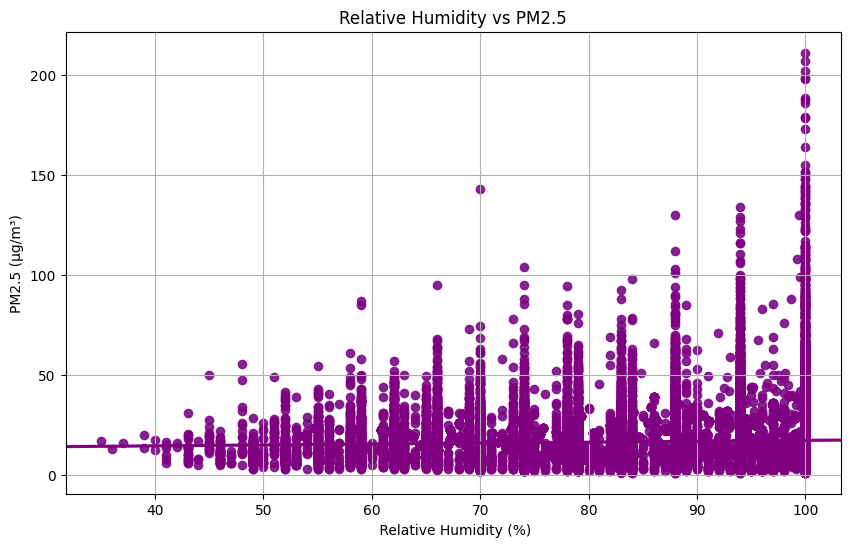

Correlation between Relative Humidity and PM2.5: 0.04


In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='rh', y='pm25', alpha=0.5,)
sns.regplot(data=df_final, x='rh', y='pm25', color='purple', truncate=False)
plt.title('Relative Humidity vs PM2.5')
plt.xlabel(' Relative Humidity (%)')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.show()
correlation = df_final['rh'].corr(df_final['pm25'])
print(f'Correlation between Relative Humidity and PM2.5: {correlation:.2f}')

#### 1. Thông số thống kê tổng quan
* **Hệ số tương quan:** $r = 0.04$
* **Đánh giá:** Tương quan dương cực kỳ yếu, gần như không có mối quan hệ tuyến tính rõ ràng giữa hai biến số.
* **Đường xu hướng:** Đường màu tím đi ngang (gần như phẳng), phản ánh việc độ ẩm tăng hay giảm không làm thay đổi giá trị trung bình của PM2.5 một cách tuyến tính trên toàn bộ tập dữ liệu.

#### 2. Phân tích hình thái dữ liệu (Visual Analysis)

##### 2.1. Sự phân bố bất thường tại mốc bão hòa (100%)
* **Hiện tượng:** Tại điểm độ ẩm đạt 100% (bên phải ngoài cùng của biểu đồ), có sự tập trung dày đặc các điểm dữ liệu với dải giá trị PM2.5 dao động cực lớn (từ 0 lên đến hơn 200 $\mu g/m^3$).
* **Ý nghĩa:** Khi không khí bão hòa hơi nước (sương mù dày hoặc sắp mưa), nồng độ bụi có thể đạt mức cực đại (nguy hại) nhưng cũng có thể rất thấp. Điều này cho thấy trạng thái "bão hòa" là một thời điểm nhạy cảm và khó dự đoán.

##### 2.2. Dải độ ẩm trung bình (60% - 90%)
* Đây là dải độ ẩm phổ biến nhất tại Cần Thơ. Dữ liệu tại đây phân tán rộng nhưng mật độ tập trung ở phần dưới (PM2.5 < 50 $\mu g/m^3$) vẫn chiếm đa số, tuy nhiên vẫn xuất hiện nhiều điểm ngoại laicao đột biến.

##### 2.3. Dải độ ẩm thấp (< 50%)
* Tại những thời điểm độ ẩm thấp (thường là giữa trưa nắng gắt), nồng độ PM2.5 có xu hướng ổn định hơn và ít xuất hiện các giá trị cực đoan (rất ít điểm vượt quá 50 $\mu g/m^3$).

#### 3. Giải thích chuyên sâu (Cơ chế vật lý & Hóa học)

Tại sao hệ số tương quan lại thấp ($0.04$) trong khi biểu đồ lại biến động mạnh? Câu trả lời nằm ở **"Tác động kép trái chiều"** của độ ẩm:

1.  **Cơ chế làm tăng ô nhiễm:**
    * Trong môi trường độ ẩm cao (đặc biệt là sương mù sáng sớm tại miền Tây), các hạt bụi mịn có tính hút ẩm (như muối, sulfate) sẽ hấp thụ hơi nước và trương nở kích thước. Điều này làm tăng nồng độ khối lượng ghi nhận được, khiến chỉ số PM2.5 tăng vọt. Đây là lý do ta thấy cột dữ liệu dựng đứng tại mốc 100%.

2.  **Cơ chế làm giảm ô nhiễm:**
    * Độ ẩm cao thường là tiền đề của mưa. Khi mưa xảy ra, bụi bị rửa trôi, làm PM2.5 giảm sâu.
    * Hơn nữa, độ ẩm quá cao làm các hạt bụi kết dính lại thành hạt to hơn và lắng xuống đất nhanh hơn (trọng lực).

**=> Kết luận:** Hai cơ chế này triệt tiêu lẫn nhau về mặt thống kê tuyến tính, dẫn đến $r \approx 0$, nhưng thực tế tác động của độ ẩm là rất mạnh và phức tạp.

#### 4. Nhận định tình hình thực tế tại Cần Thơ

Kết hợp với dữ liệu địa phương, biểu đồ này kể một câu chuyện cụ thể:

* **Sương mù quang hóa:** Những điểm dữ liệu có độ ẩm 100% và PM2.5 cao (>150) khả năng cao phản ánh những buổi sáng sớm có sương mù dày đặc tại Cần Thơ. Lúc này, hơi nước giữ chặt bụi lơ lửng ở tầng thấp, tạo thành lớp mù cực kỳ độc hại cho hệ hô hấp.
* **Sai số thiết bị:** Cần lưu ý rằng ở độ ẩm 100%, một số cảm biến đo bụi bằng laser giá rẻ có thể nhầm lẫn giữa hạt sương (hơi nước) và hạt bụi, dẫn đến kết quả đo cao hơn thực tế.


### Ảnh hưởng của nhiệt độ đến chất lượng không khí

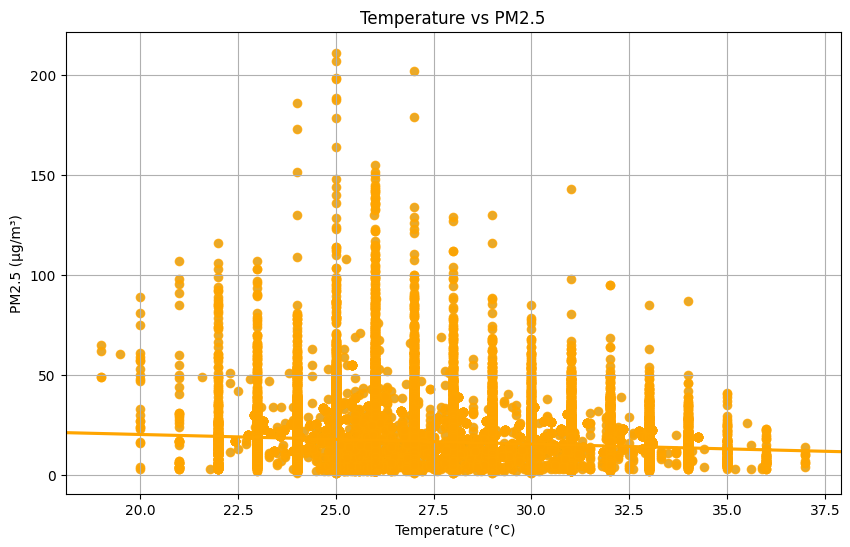

Correlation between Temperature and PM2.5: -0.09


In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='temp', y='pm25', alpha=0.5,)
sns.regplot(data=df_final, x='temp', y='pm25', color='orange', truncate=False)
plt.title('Temperature vs PM2.5')
plt.xlabel(' Temperature (°C)')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.show()
correlation = df_final['temp'].corr(df_final['pm25'])
print(f'Correlation between Temperature and PM2.5: {correlation:.2f}')

#### 1. Thông số thống kê cơ bản
* **Hệ số tương quan (Pearson Correlation):** $r = -0.09$
* **Loại tương quan:** Tương quan nghịch, mức độ rất yếu (Very Weak Negative Correlation).
* **Xu hướng chung:** Đường hồi quy có độ dốc đi xuống nhẹ. Khi nhiệt độ tăng, nồng độ bụi mịn có xu hướng giảm nhẹ, nhưng sự phân tán dữ liệu là rất lớn.

#### 2. Phân tích hình thái dữ liệu

##### 2.1. Vùng tập trung ô nhiễm cao (24°C - 28°C)
* **Mật độ:** Đây là vùng tập trung dày đặc nhất các điểm dữ liệu.
* **Cực trị:** Hầu hết các giá trị PM2.5 cao đột biến (trên 150 - 200 $\mu g/m^3$) đều xuất hiện trong khoảng nhiệt độ này.
* **Ngữ cảnh:** Khoảng nhiệt độ 24-28°C tại Cần Thơ thường tương ứng với thời điểm **buổi sáng sớm hoặc ban đêm/chiều tối**. Đây là lúc hoạt động giao thông cao điểm hoặc sinh hoạt gia tăng, nhưng nhiệt độ chưa đủ cao để tạo ra dòng đối lưu mạnh.

##### 2.2. Vùng nhiệt độ cao (Trên 32°C)
* **Xu hướng giảm:** Khi nhiệt độ vượt quá 30°C và tiến về phía 35-37°C (thời điểm giữa trưa và đầu giờ chiều), các điểm dữ liệu thưa thớt hơn ở phần trên cao của trục tung.
* **Mức độ ô nhiễm:** Rất ít điểm dữ liệu vượt quá 100 $\mu g/m^3$ ở ngưỡng nhiệt độ này. Điều này củng cố cho hệ số tương quan âm (-0.09).

##### 2.3. Vùng nhiệt độ thấp (Dưới 22°C)
* Dữ liệu rải rác, nhưng vẫn tồn tại các điểm ô nhiễm cao. Tại Cần Thơ, nhiệt độ này thường chỉ xuất hiện vào đêm khuya hoặc sáng sớm trong các tháng mùa đông (gần Tết), thường đi kèm với sương mù giữ bụi.

#### 3. Giải thích cơ chế khí tượng (Tại sao nóng hơn lại sạch hơn?)

Mặc dù hệ số tương quan thấp, nhưng dấu âm (-) phản ánh đúng cơ chế vật lý của khí quyển nhiệt đới:

1.  **Đối lưu nhiệt (Thermal Convection):** Khi mặt đất bị đốt nóng vào giữa trưa (nhiệt độ cao), không khí nóng nhẹ hơn sẽ bay lên cao, tạo ra các dòng đối lưu thẳng đứng mạnh mẽ. Dòng khí này mang theo bụi mịn khuếch tán lên tầng khí quyển cao hơn và loãng đi.
2.  **Phá vỡ nghịch nhiệt:** Nhiệt độ cao giúp phá vỡ các lớp nghịch nhiệt (inversion layers) thường hình thành vào ban đêm, giải phóng lượng bụi bị "nhốt" sát mặt đất.
3.  **Gió:** Nhiệt độ cao thường đi kèm với gió mạnh hơn vào ban ngày, hỗ trợ việc phát tán chất ô nhiễm.

#### 4. Nhận định đặc thù cho Cần Thơ

Dựa trên biểu đồ, ta có thể xây dựng "Hành trình chất lượng không khí trong ngày" tại Cần Thơ:

* **Nguy cơ cao nhất (Sáng & Tối):** Khi nhiệt độ ở mức trung bình (24-28°C), kết hợp với giờ cao điểm giao thông và không khí tù đọng, nồng độ PM2.5 dễ dàng đạt đỉnh.
* **An toàn hơn (Giữa trưa):** Mặc dù nắng nóng gây khó chịu (33-36°C), nhưng đây lại là thời điểm không khí "thoáng" nhất về mặt bụi mịn do sự khuếch tán nhiệt.

#### 5. Kết luận
Nhiệt độ không phải là nguyên nhân trực tiếp sinh ra bụi, nhưng nó đóng vai trò **"người điều phối"**. Nhiệt độ càng cao, khả năng phát tán bụi càng tốt (tương quan nghịch). Ngược lại, nhiệt độ mát mẻ/trung bình thường là lúc bụi tích tụ nhiều nhất.

### Ảnh hưởng của tốc độ gió đối với chất lượng không khí

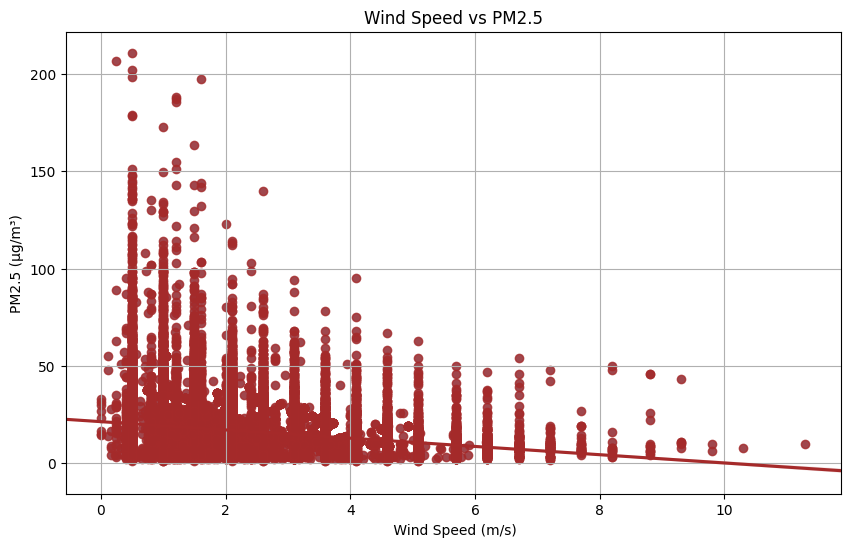

Correlation between Wind Speed and PM2.5: -0.20


In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='wind_spd', y='pm25', alpha=0.5,)
sns.regplot(data=df_final, x='wind_spd', y='pm25', color='brown', truncate=False)
plt.title('Wind Speed vs PM2.5')
plt.xlabel(' Wind Speed (m/s)')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True) 
plt.show()
correlation = df_final['wind_spd'].corr(df_final['pm25'])
print(f'Correlation between Wind Speed and PM2.5: {correlation:.2f}')

#### 1. Thông số thống kê định lượng.
* **Hệ số tương quan (Pearson Correlation):** $r = -0.20$
* **Loại tương quan:** Tương quan nghịch (Negative Correlation).
* **Đánh giá mức độ:** Mức độ tương quan trung bình yếu về mặt thống kê tuyến tính, nhưng có ý nghĩa vật lý rất rõ ràng về mặt "giới hạn trên" của ô nhiễm.

#### 2. Phân tích Khám phá Dữ liệu (Exploratory Data Analysis - EDA)

Quan sát trực quan biểu đồ phân tán (Scatter Plot) màu đỏ nâu, ta thấy rõ 3 vùng đặc trưng:

##### 2.1. Vùng "Lặng gió" và Ô nhiễm cực đại (0 - 2 m/s)
* **Mật độ:** Đây là khu vực tập trung nhiều điểm dữ liệu nhất. Điều này cho thấy điều kiện gió tại Cần Thơ thường ở mức nhẹ hoặc lặng gió.
* **Biến động:** Tại tốc độ gió thấp (< 2 m/s), nồng độ PM2.5 biến động cực mạnh, trải dài từ mức rất sạch (gần 0) đến mức nguy hại (vượt 200 $\mu g/m^3$).
* **Nguyên nhân:** Khi gió yếu, không khí rơi vào trạng thái **tù đọng (stagnation)**. Các chất ô nhiễm từ xe máy, hoạt động sinh hoạt không thể phát tán đi xa mà tích tụ ngay tại nguồn phát.

##### 2.2. Vùng "Khuếch tán hiệu quả" (Trên 4 m/s)
* **Xu hướng:** Khi tốc độ gió tăng lên trên 4 m/s, biểu đồ cho thấy một sự "cắt ngọn" rõ rệt. Hầu như không còn xuất hiện các điểm dữ liệu có PM2.5 cao trên 100 $\mu g/m^3$.
* **Đường xu hướng:** Đường hồi quy (Trendline) dốc xuống, khẳng định gió càng mạnh thì nồng độ bụi trung bình càng giảm.

##### 2.3. Vùng "Gió mạnh" (Trên 8 m/s)
* Tại các mốc gió lớn (8 - 10 m/s), nồng độ bụi duy trì ở mức rất thấp và ổn định (thường dưới 30 $\mu g/m^3$). Gió mạnh đóng vai trò như một "cây chổi" quét sạch bầu khí quyển.

#### 3. Nhận định chuyên sâu gắn với bối cảnh Cần Thơ

Từ biểu đồ trên, có thể rút ra các đặc điểm khí tượng ảnh hưởng đến chất lượng không khí (CLKK) tại Cần Thơ như sau:

1.  **Vai trò của gió sông Hậu:**
    Cần Thơ có lợi thế nằm bên sông Hậu. Những ngày có gió chướng hoặc gió từ sông thổi vào mạnh sẽ giúp CLKK cải thiện ngay lập tức (nhìn vào phần đuôi bên phải của biểu đồ).

2.  **Hiệu ứng hẻm phố (Street Canyon Effect):**
    Phần lớn dữ liệu tập trung ở khoảng 0-2 m/s cảnh báo về nguy cơ ô nhiễm cục bộ trong các đô thị. Tại các tuyến phố hẹp, nhà cao tầng ở trung tâm Ninh Kiều, gió tự nhiên bị cản lại. Nếu tốc độ gió chung chỉ đạt 1-2 m/s, thì trong các con hẻm gần như là 0 m/s, khiến khói bụi xe máy tích tụ đậm đặc ngang tầm mũi người đi đường.

3.  **Tương quan nghịch (-0.20) có ý nghĩa gì?**
    Con số -0.20 tuy không lớn (do vẫn có những lúc gió nhẹ nhưng không khí sạch vì ít nguồn thải), nhưng nó xác nhận quy luật: **Gió là cơ chế làm sạch tự nhiên quan trọng thứ 2 (sau mưa).** Thiếu gió là điều kiện cần để xảy ra các đợt ô nhiễm cấp tính.

#### 4. Kết luận
Tốc độ gió là yếu tố then chốt quyết định khả năng **phát tán và pha loãng** bụi mịn. Nguy cơ ô nhiễm không khí tại Cần Thơ cao nhất khi trời lặng gió (Wind Speed < 2 m/s), và giảm đáng kể khi gió đạt trên 4 m/s.
